# Домашнее задание № 2

<pre>
ФИО: Никифоров Владимир
</pre>

## Rosbank ML Competition

Ссылка на соревнование: https://boosters.pro/champ_15

Росбанк – часть ведущей международной финансовой группы Societe Generale, банк включен ЦБ РФ в число 11 системно значимых кредитных организаций России. Инновации неотъемлемый процесс работы Росбанка, поэтому активно развивается направленный анализа больших данных.

- Данные

Датасет, который содержит историю транзакций клиентов за 3 месяца льготного использования банковского продукта

- Задача

Задача бинарной классификации – прогноз оттока клиентов

Колонка cl_id содержит вутренний id клиента. Для каждого уникальнго cl_id следует предсказать продолжит ли клиент пользоваться продуктом (target_flag). Значение 0 соответствует отказу, а значение 1 соответствует продолжению использования

1. Наборы данных вида Transactions (несколько транзакций на одного клиента) трансформировать в таблицу, где cl_id будут уникальными (соответственно 4000 строк в train и 1000 строк в test
2. Для каждого cl_id будет уникальное целевое событие target_flag, а также уникальный канал привлечения клиента channel_type (клиент привлекается лишь однажды и с самого начала его записи присваивается значение канала привлечения)
3. При агрегации (*pandas.DataFrame.groupby*) по cl_id (или по связке cl_id, channel_type, target_flag) необходимо создавать производные фичи, идеи для таких фичей могут быть следующими:

    - общая сумма транзакций по каждой из trx_category
    - общая сумма транзакции по основным вылютам (напр. выделить рубли, доллары и евро - предположительно, это будут самые крупные категории)
    - общая сумма транзакций по категориям MCC кодов (например, выбрать основные/популярные MCC коды). ВНИМАНИ! Некоторые MCC коды из train могут быть не представлены в test. Про MCC коды в целом: http://www.banki.ru/wikibank/mcc-kod/; Справочник MCC кодов: https://mcc-codes.ru/code; Про некоторые категории кэшбека Росбанка: https://mcc-codes.ru/card/rosbank-sverkh-plus;
    - возможные агрегации по времени суток и дням недели - траты в выходные (праздники) или будни, в ночное время или в рабочее и т.д.
4. **Обязательная часть**: провести первичный анализ данных - посмотреть распределения признаков, выделить самые популярные MCC, помотреть активность клиентов по дням недели/времени, какие категории транзакции (trx_category) наиболее популярны и т.д. Получить инсайты, которые в дальнейшем помогут вам правильно подготовить фичи
5. **Дополнительная часть**: с отобранными фичами и полученными компонентами обучить модель (тип алгоритма на свой вкус, можно начать с линейной) и померить качество на локальном тестовом наборе данных (локальная валидация), который создается в этом ноутбуке. **Метрика оценки качества - ROC AUC**(https://en.wikipedia.org/wiki/Receiver_operating_characteristic)
6. Задания принимаются в виде ноутбука с кодов/картинками выполненной обязательной части

При возникновении вопросов и для отправки домашнего задания - egsachko@gmail.com или http://fb.com/sachkoe
    

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime
import dateutil.relativedelta

import xgboost
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel

In [2]:
raw_df = pd.read_csv('../data/rosbank_train.csv')
raw_df.head(5)
# target_sum - можно выкинуть, переменная участвует в другой задаче

PERIOD  cl_id   MCC channel_type  currency        TRDATETIME   amount  \
0  01/10/2017      0  5200          NaN       810  21OCT17:00:00:00   5023.0   
1  01/10/2017      0  6011          NaN       810  12OCT17:12:24:07  20000.0   
2  01/12/2017      0  5921          NaN       810  05DEC17:00:00:00    767.0   
3  01/10/2017      0  5411          NaN       810  21OCT17:00:00:00   2031.0   
4  01/10/2017      0  6012          NaN       810  24OCT17:13:14:24  36562.0   

  trx_category  target_flag  target_sum  
0          POS            0         0.0  
1      DEPOSIT            0         0.0  
2          POS            0         0.0  
3          POS            0         0.0  
4      C2C_OUT            0         0.0

In [3]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490513 entries, 0 to 490512
Data columns (total 10 columns):
PERIOD          490513 non-null object
cl_id           490513 non-null int64
MCC             490513 non-null int64
channel_type    487603 non-null object
currency        490513 non-null int64
TRDATETIME      490513 non-null object
amount          490513 non-null float64
trx_category    490513 non-null object
target_flag     490513 non-null int64
target_sum      490513 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 37.4+ MB


In [4]:
print("Total clients: ", len(raw_df.cl_id.unique()))

Total clients:  5000


Всего 5000 клиентов, случайным образом возьмем 1000 клиентов для тестирования

In [5]:
cl_ids_test = np.random.choice(raw_df.cl_id.unique(), size=1000, replace=False)
cl_ids_test_set = set(cl_ids_test)

In [6]:
# create transactions dataset for train
transactions_train = raw_df[~raw_df.cl_id.isin(cl_ids_test)].copy()
print("Total transactions in train dataset: ", len(transactions_train))
# create transactions dataset for test
transactions_test = raw_df[raw_df.cl_id.isin(cl_ids_test)].copy()
print("Total transactions in test dataset: ", len(transactions_test))

Total transactions in train dataset:  389909
Total transactions in test dataset:  100604


### 1. Наборы данных вида Transactions (несколько транзакций на одного клиента) трансформировать в таблицу, где cl_id будут уникальными (соответственно 4000 строк в train и 1000 строк в test

In [7]:
def get_aggregated_df(df, agg_type, col_to_groupby):
    agg_df = df[['cl_id', col_to_groupby, 'amount']].groupby(['cl_id', col_to_groupby]).agg([agg_type])
    agg_df = agg_df.unstack(fill_value=0)
    agg_df.columns = agg_df.columns.get_level_values(2)

    old_name = agg_df.columns.name
    old_cols = agg_df.columns
    new_cols = [old_name + '_' + agg_type + '_' + str(old_col) for old_col in old_cols]
    agg_df.rename(
        columns={old_col: new_col for old_col, new_col in zip(old_cols, new_cols)}, inplace=True
    )
    return agg_df

In [8]:
agg_df = get_aggregated_df(raw_df, 'sum', 'MCC')

In [9]:
agg_df.head()

MCC    MCC_sum_742  MCC_sum_763  MCC_sum_780  MCC_sum_1520  MCC_sum_1711  \
cl_id                                                                      
0              0.0          0.0          0.0           0.0           0.0   
1              0.0          0.0          0.0           0.0           0.0   
5              0.0          0.0          0.0           0.0           0.0   
9              0.0          0.0          0.0           0.0           0.0   
10             0.0          0.0          0.0           0.0           0.0   

MCC    MCC_sum_1731  MCC_sum_1750  MCC_sum_1799  MCC_sum_2741  MCC_sum_2842  \
cl_id                                                                         
0               0.0           0.0           0.0           0.0           0.0   
1               0.0           0.0           0.0           0.0           0.0   
5               0.0           0.0           0.0           0.0           0.0   
9               0.0           0.0           0.0           0.0           0.0   
10              0.0           0.0           0.0           0.0           0.0   

MCC        ...       MCC_sum_8699  MCC_sum_8911  MCC_sum_8931  MCC_sum_8999  \
cl_id      ...                                                                
0          ...                0.0           0.0           0.0           0.0   
1          ...                0.0           0.0           0.0           0.0   
5          ...                0.0           0.0           0.0           0.0   
9          ...                0.0           0.0           0.0           0.0   
10         ...                0.0           0.0           0.0        2400.0   

MCC    MCC_sum_9211  MCC_sum_9222  MCC_sum_9311  MCC_sum_9399  MCC_sum_9402  \
cl_id                                                                         
0               0.0           0.0           0.0           0.0           0.0   
1               0.0           0.0         210.0           0.0           0.0   
5               0.0        3825.0           0.0           0.0           0.0   
9               0.0           0.0           0.0           0.0           0.0   
10              0.0           0.0           0.0           0.0           0.0   

MCC    MCC_sum_9405  
cl_id                
0               0.0  
1               0.0  
5               0.0  
9               0.0  
10              0.0  

[5 rows x 344 columns]

In [10]:
agg_df = agg_df.reset_index()
agg_df.columns

Index(['cl_id', 'MCC_sum_742', 'MCC_sum_763', 'MCC_sum_780', 'MCC_sum_1520',
       'MCC_sum_1711', 'MCC_sum_1731', 'MCC_sum_1750', 'MCC_sum_1799',
       'MCC_sum_2741',
       ...
       'MCC_sum_8699', 'MCC_sum_8911', 'MCC_sum_8931', 'MCC_sum_8999',
       'MCC_sum_9211', 'MCC_sum_9222', 'MCC_sum_9311', 'MCC_sum_9399',
       'MCC_sum_9402', 'MCC_sum_9405'],
      dtype='object', name='MCC', length=345)

In [11]:
# create transactions dataset for train
transactions_train = agg_df[~agg_df.cl_id.isin(cl_ids_test)][['cl_id']].copy()
print("Total transactions in train dataset: ", len(transactions_train))
# create transactions dataset for test
transactions_test = agg_df[agg_df.cl_id.isin(cl_ids_test)][['cl_id']].copy()
print("Total transactions in test dataset: ", len(transactions_test))

Total transactions in train dataset:  4000
Total transactions in test dataset:  1000


In [12]:
transactions_train['target_flag'] = transactions_train.apply(lambda x: max(raw_df[raw_df['cl_id'] == x['cl_id']]['target_flag']), axis=1)
transactions_train['channel_type'] = transactions_train.apply(lambda x: raw_df[raw_df['cl_id'] == x['cl_id']].groupby('cl_id')[['channel_type']].first().values[0][0], axis=1)
transactions_test['target_flag'] = transactions_test.apply(lambda x: max(raw_df[raw_df['cl_id'] == x['cl_id']]['target_flag']), axis=1)
transactions_test['channel_type'] = transactions_test.apply(lambda x: raw_df[raw_df['cl_id'] == x['cl_id']].groupby('cl_id')[['channel_type']].first().values[0][0], axis=1)

In [13]:
transactions_train.head()

MCC  cl_id  target_flag channel_type
1        1            0          NaN
2        5            1          NaN
3        9            0          NaN
4       10            0          NaN
5       11            0          NaN

In [14]:
#При агрегации (pandas.DataFrame.groupby) по cl_id (или по связке cl_id, channel_type, target_flag) необходимо создавать производные фичи, идеи для таких фичей могут быть следующими:
#общая сумма транзакций по каждой из trx_category
for trx in list(raw_df.trx_category.unique()):
    raw_df['sum_trx_%s' % trx] = raw_df[(raw_df.trx_category == trx)].groupby('cl_id')['amount'].sum()    

In [15]:
#общая сумма транзакции по основным вылютам (напр. выделить рубли, доллары и евро - предположительно, это будут самые крупные категории)
print(raw_df.currency.value_counts().head(3))
for cur in list(raw_df.currency.value_counts().head(3).index): #list(raw_df.currency.unique()):
    raw_df['sum_cur_%s' % cur] = raw_df[(raw_df.currency == cur)].groupby('cl_id')['amount'].sum()

810    477644
978      5536
840      1921
Name: currency, dtype: int64


In [16]:
raw_df.MCC.value_counts()

5411    121640
6011     54382
5814     41351
5812     30027
5499     27237
5541     19816
5912     18728
5999     13073
6012     10056
5921      8578
5331      7641
4121      6266
5211      6262
4829      6205
5691      5161
5261      4803
4111      4362
5977      4300
5200      3460
5732      3271
5311      3258
5533      2946
5651      2915
4812      2857
5641      2710
8099      2674
5722      2667
5661      2601
8999      2599
5941      2597
         ...  
3064         1
3678         1
8675         1
3548         1
3607         1
3730         1
3029         1
3535         1
3722         1
7333         1
7339         1
3387         1
3715         1
3508         1
3640         1
3513         1
3515         1
3191         1
5937         1
3634         1
3520         1
7217         1
3659         1
3628         1
3778         1
5960         1
3625         1
7211         1
7631         1
3703         1
Name: MCC, Length: 344, dtype: int64

In [17]:
#общая сумма транзакций по категориям MCC кодов (например, выбрать основные/популярные MCC коды). ВНИМАНИ! Некоторые MCC коды из train могут быть не представлены в test.
# Возьмем МСС top10
for mcc in list(raw_df.MCC.value_counts().head(10).index):
    raw_df['sum_mcc_%s' % mcc] = raw_df[(raw_df.MCC == mcc)].groupby('cl_id')['amount'].sum()

In [18]:
raw_df.head()

PERIOD  cl_id   MCC channel_type  currency        TRDATETIME   amount  \
0  01/10/2017      0  5200          NaN       810  21OCT17:00:00:00   5023.0   
1  01/10/2017      0  6011          NaN       810  12OCT17:12:24:07  20000.0   
2  01/12/2017      0  5921          NaN       810  05DEC17:00:00:00    767.0   
3  01/10/2017      0  5411          NaN       810  21OCT17:00:00:00   2031.0   
4  01/10/2017      0  6012          NaN       810  24OCT17:13:14:24  36562.0   

  trx_category  target_flag  target_sum      ...       sum_mcc_5411  \
0          POS            0         0.0      ...            2031.00   
1      DEPOSIT            0         0.0      ...           14629.46   
2          POS            0         0.0      ...                NaN   
3          POS            0         0.0      ...                NaN   
4      C2C_OUT            0         0.0      ...                NaN   

   sum_mcc_6011  sum_mcc_5814  sum_mcc_5812  sum_mcc_5499  sum_mcc_5541  \
0       20000.0           NaN           NaN           NaN           NaN   
1      145000.0      82441.17       3180.01         492.8           NaN   
2           NaN           NaN           NaN           NaN           NaN   
3           NaN           NaN           NaN           NaN           NaN   
4           NaN           NaN           NaN           NaN           NaN   

   sum_mcc_5912  sum_mcc_5999  sum_mcc_6012  sum_mcc_5921  
0           NaN           NaN       36562.0         767.0  
1        2441.0         675.0           NaN           NaN  
2           NaN           NaN           NaN           NaN  
3           NaN           NaN           NaN           NaN  
4           NaN           NaN           NaN           NaN  

[5 rows x 33 columns]

In [19]:
# возможные агрегации по времени суток и дням недели - траты в выходные (праздники) или будни, в ночное время или в рабочее и т.д.

In [20]:
for ct in list(raw_df.channel_type.value_counts().head(10).index):
    raw_df['sum_ct_%s' % ct] = raw_df[(raw_df.channel_type == ct)].groupby('cl_id')['amount'].sum()

In [21]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490513 entries, 0 to 490512
Data columns (total 38 columns):
PERIOD                    490513 non-null object
cl_id                     490513 non-null int64
MCC                       490513 non-null int64
channel_type              487603 non-null object
currency                  490513 non-null int64
TRDATETIME                490513 non-null object
amount                    490513 non-null float64
trx_category              490513 non-null object
target_flag               490513 non-null int64
target_sum                490513 non-null float64
sum_trx_POS               5000 non-null float64
sum_trx_DEPOSIT           2864 non-null float64
sum_trx_C2C_OUT           1237 non-null float64
sum_trx_WD_ATM_ROS        2771 non-null float64
sum_trx_BACK_TRX          1439 non-null float64
sum_trx_WD_ATM_PARTNER    1769 non-null float64
sum_trx_WD_ATM_OTHER      1239 non-null float64
sum_trx_C2C_IN            1621 non-null float64
sum_trx_CAT      

In [22]:
def transaction_by_day_count(dataset):
    dataset['day_of_transaction'] = dataset['TRDATETIME'].apply(
        lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')).strftime('%w')
    ) 
    tmp_df = dataset.groupby(
        ['cl_id','day_of_transaction']
    )['day_of_transaction'].size().unstack().fillna(0).reset_index()
    old_columns = [
        old_col for old_col in tmp_df.columns.tolist()
        if old_col in dataset['day_of_transaction'].unique()
    ]
    tmp_df.rename(
        columns={old_col: 'day_' + old_col for old_col in old_columns},
        inplace=True
    )
    return tmp_df
    
    

def transaction_by_hour_count(dataset):
    dataset['hour_of_transaction'] = dataset['TRDATETIME'].apply(
        lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')).strftime('%H')
    ) 
    return dataset.groupby(
        ['cl_id','hour_of_transaction']
    )['hour_of_transaction'].size().unstack().fillna(0).reset_index()

In [23]:
trn = transaction_by_day_count(raw_df)
raw_df = pd.merge(raw_df, trn, on=['cl_id']).fillna(0)
trn = transaction_by_hour_count(raw_df)
raw_df = pd.merge(raw_df, trn, on=['cl_id']).fillna(0)

In [24]:
raw_df.head()

PERIOD  cl_id   MCC channel_type  currency        TRDATETIME   amount  \
0  01/10/2017      0  5200            0       810  21OCT17:00:00:00   5023.0   
1  01/10/2017      0  6011            0       810  12OCT17:12:24:07  20000.0   
2  01/12/2017      0  5921            0       810  05DEC17:00:00:00    767.0   
3  01/10/2017      0  5411            0       810  21OCT17:00:00:00   2031.0   
4  01/10/2017      0  6012            0       810  24OCT17:13:14:24  36562.0   

  trx_category  target_flag  target_sum ...    14   15   16   17   18   19  \
0          POS            0         0.0 ...   0.0  0.0  0.0  0.0  0.0  0.0   
1      DEPOSIT            0         0.0 ...   0.0  0.0  0.0  0.0  0.0  0.0   
2          POS            0         0.0 ...   0.0  0.0  0.0  0.0  0.0  0.0   
3          POS            0         0.0 ...   0.0  0.0  0.0  0.0  0.0  0.0   
4      C2C_OUT            0         0.0 ...   0.0  0.0  0.0  0.0  0.0  0.0   

    20   21   22   23  
0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  
2  0.0  0.0  0.0  0.0  
3  0.0  0.0  0.0  0.0  
4  0.0  0.0  0.0  0.0  

[5 rows x 71 columns]

In [25]:
len(list(raw_df.columns))

71

In [26]:
raw_df[list(set(raw_df.columns).difference(['PERIOD', 'MCC', 'channel_type', 'currency', 'TRDATETIME', 'amount', 'trx_category', 'target_sum']))].head()

target_flag   07  sum_ct_type2   08   01  sum_trx_DEPOSIT  day_2  \
0            0  0.0           0.0  0.0  0.0          20000.0    2.0   
1            0  0.0           0.0  0.0  0.0          95000.0    2.0   
2            0  0.0           0.0  0.0  0.0              0.0    2.0   
3            0  0.0           0.0  0.0  0.0              0.0    2.0   
4            0  0.0           0.0  0.0  0.0              0.0    2.0   

   sum_trx_POS  cl_id   04  ...    sum_mcc_5921   19  sum_mcc_5411  \
0      7821.00      0  0.0  ...           767.0  0.0       2031.00   
1    122578.04      0  0.0  ...             0.0  0.0      14629.46   
2         0.00      0  0.0  ...             0.0  0.0          0.00   
3         0.00      0  0.0  ...             0.0  0.0          0.00   
4         0.00      0  0.0  ...             0.0  0.0          0.00   

   sum_cur_810   17   16   06  sum_trx_WD_ATM_ROS  sum_cur_978  day_3  
0     64383.00  0.0  0.0  0.0                 0.0         0.00    0.0  
1    266693.13  0.0  0.0  0.0             50000.0       884.91    0.0  
2         0.00  0.0  0.0  0.0                 0.0         0.00    0.0  
3         0.00  0.0  0.0  0.0                 0.0         0.00    0.0  
4         0.00  0.0  0.0  0.0                 0.0         0.00    0.0  

[5 rows x 63 columns]

In [27]:
for fld in list(set(raw_df.columns).difference(['PERIOD', 'cl_id', 'MCC', 'channel_type', 'currency', 'TRDATETIME', 'amount', 'trx_category', 
                                                'target_sum', 'day_of_transaction', 'hour_of_transaction'])):
    #print(fld)
    transactions_train[fld] = transactions_train.apply(lambda x: max(raw_df[raw_df['cl_id'] == x['cl_id']][fld]) if fld == 'target_flag' else sum(raw_df[raw_df['cl_id'] == x['cl_id']][fld]), axis=1)
    transactions_test[fld] = transactions_test.apply(lambda x: max(raw_df[raw_df['cl_id'] == x['cl_id']][fld]) if fld == 'target_flag' else sum(raw_df[raw_df['cl_id'] == x['cl_id']][fld]), axis=1)

In [28]:
transactions_train.head()

MCC  cl_id  target_flag channel_type      07  sum_ct_type2      08      01  \
1        1            0          NaN     0.0  0.000000e+00     0.0     0.0   
2        5            1          NaN     0.0  0.000000e+00     0.0     0.0   
3        9            0          NaN     0.0  2.516975e+06     0.0    39.0   
4       10            0          NaN  7871.0  1.268465e+08  6019.0  1389.0   
5       11            0          NaN     0.0  6.104711e+07     0.0     0.0   

MCC  sum_trx_DEPOSIT    day_2  sum_trx_POS   ...     sum_mcc_5921     19  \
1          7329878.0   2080.0  11291008.32   ...         57461.23  208.0   
2         16064230.0   2698.0  13218534.98   ...         45766.54  284.0   
3          1414300.0    273.0   3120573.20   ...         14463.83    0.0   
4         12186450.0  28706.0  50408476.46   ...        485697.65    0.0   
5          4643250.0   6510.0  30618725.62   ...        179963.91  434.0   

MCC  sum_mcc_5411   sum_cur_810      17      16      06  sum_trx_WD_ATM_ROS  \
1      2778715.31  2.585381e+07     0.0     0.0     0.0           3826400.0   
2      1313217.99  4.329022e+07   568.0   142.0     0.0           8287500.0   
3       337793.65  6.196515e+06    39.0    78.0     0.0            128600.0   
4      7177443.90  1.219997e+08  1852.0  1852.0  8797.0          25539100.0   
5      3169532.20  4.441152e+07   651.0   217.0     0.0          15161100.0   

MCC  sum_cur_978    day_3  
1        6562.21   1664.0  
2        5797.72   2130.0  
3        1918.80    195.0  
4       36009.08  31484.0  
5       14227.37   5425.0  

[5 rows x 62 columns]

In [29]:
# для получения наиболее полной информации о взаимодействии количественных признаков (в лоб) между собой в pandas-DataFrame воспользуемся библиотекой seaborn и ее методом pairplot:
#sns.pairplot(transactions_train);

In [30]:
# Проверим сами значения корреляции между числовыми признаками датасета:
transactions_train.corr(method ='pearson')

MCC                        cl_id  target_flag        07  sum_ct_type2  \
MCC                                                                     
cl_id                   1.000000    -0.391325 -0.049704     -0.104284   
target_flag            -0.391325     1.000000  0.061885     -0.018884   
07                     -0.049704     0.061885  1.000000      0.271144   
sum_ct_type2           -0.104284    -0.018884  0.271144      1.000000   
08                     -0.046988     0.060935  0.553882      0.222391   
01                     -0.054226     0.042926  0.229046      0.197814   
sum_trx_DEPOSIT        -0.175173     0.034722  0.108670      0.348283   
day_2                  -0.097603     0.182227  0.288351      0.092909   
sum_trx_POS            -0.156241     0.010379  0.170021      0.633685   
04                     -0.046010     0.029797  0.556142      0.422623   
sum_trx_WD_ATM_PARTNER -0.162347     0.021671  0.213137      0.652956   
02                     -0.035896     0.038361  0.285662      0.179120   
day_1                  -0.100684     0.179658  0.270202      0.065551   
21                     -0.014088     0.051101  0.102675      0.014584   
10                     -0.031089     0.075808  0.345326      0.060568   
12                     -0.046394     0.057291  0.432926      0.291262   
20                     -0.036007     0.060654  0.099421      0.016172   
sum_ct_type4           -0.030004     0.012207 -0.003669      0.000151   
03                     -0.033484     0.051642  0.489928      0.296026   
09                     -0.047479     0.076992  0.411588      0.226136   
13                     -0.044751     0.103991  0.272361      0.108188   
00                     -0.107156     0.190848  0.245930      0.073543   
sum_ct_type5           -0.037338    -0.007912 -0.004563     -0.001319   
14                     -0.047156     0.099222  0.286562      0.103376   
day_0                  -0.102118     0.177059  0.292462      0.113773   
sum_mcc_5912           -0.175729     0.010996  0.206842      0.675627   
sum_mcc_6011           -0.175052     0.020773  0.155052      0.634966   
sum_mcc_5541           -0.175248     0.017124  0.216978      0.624969   
day_4                  -0.101243     0.185671  0.280370      0.103112   
day_5                  -0.112600     0.189218  0.269660      0.078403   
...                          ...          ...       ...           ...   
sum_mcc_6012           -0.168703     0.014743  0.202336      0.601306   
sum_mcc_5499           -0.141488     0.005660  0.122424      0.611765   
23                     -0.017627     0.060690  0.046098      0.003357   
sum_mcc_5812           -0.079711    -0.003432  0.069418      0.216334   
22                     -0.038286     0.050446  0.045203      0.007163   
18                     -0.027219     0.056203  0.066198      0.028430   
11                     -0.036613     0.071503  0.310947      0.088766   
sum_ct_type1           -0.131333     0.038609  0.001536     -0.004747   
15                     -0.005919     0.083838  0.169771      0.047575   
sum_trx_BACK_TRX       -0.119592     0.019258  0.040985      0.186926   
sum_trx_C2C_OUT        -0.162299     0.012253  0.189619      0.727390   
05                     -0.022040     0.057864  0.566111      0.225955   
day_6                  -0.099281     0.172546  0.306485      0.119072   
sum_cur_840            -0.110746     0.024461  0.113838      0.330304   
sum_trx_CASH_ADV       -0.058656    -0.014011  0.173461      0.256305   
sum_trx_CAT            -0.103996    -0.001325  0.177438      0.460814   
sum_ct_type3           -0.030505     0.011542 -0.003769      0.019473   
sum_mcc_5999           -0.170207     0.014567  0.225032      0.625177   
sum_trx_C2C_IN         -0.129950     0.006234  0.354595      0.559791   
sum_trx_WD_ATM_OTHER   -0.071082    -0.011374  0.043914      0.299075   
sum_mcc_5921           -0.164135     0.016592  0.263130      0.745537   
19                     -0.013929     0.055237  0.103248   

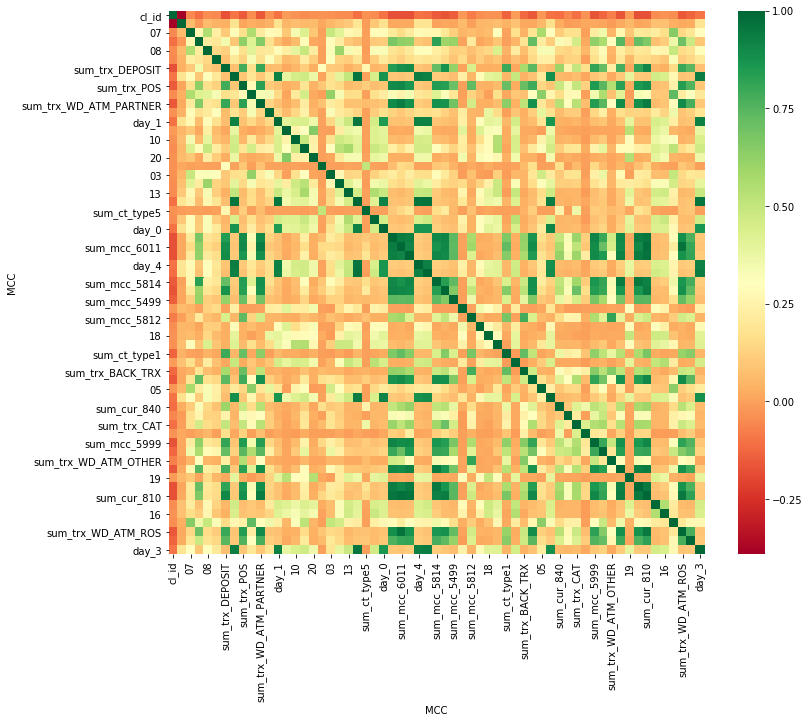

In [31]:
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(transactions_train.corr(),annot=False,cmap="RdYlGn");

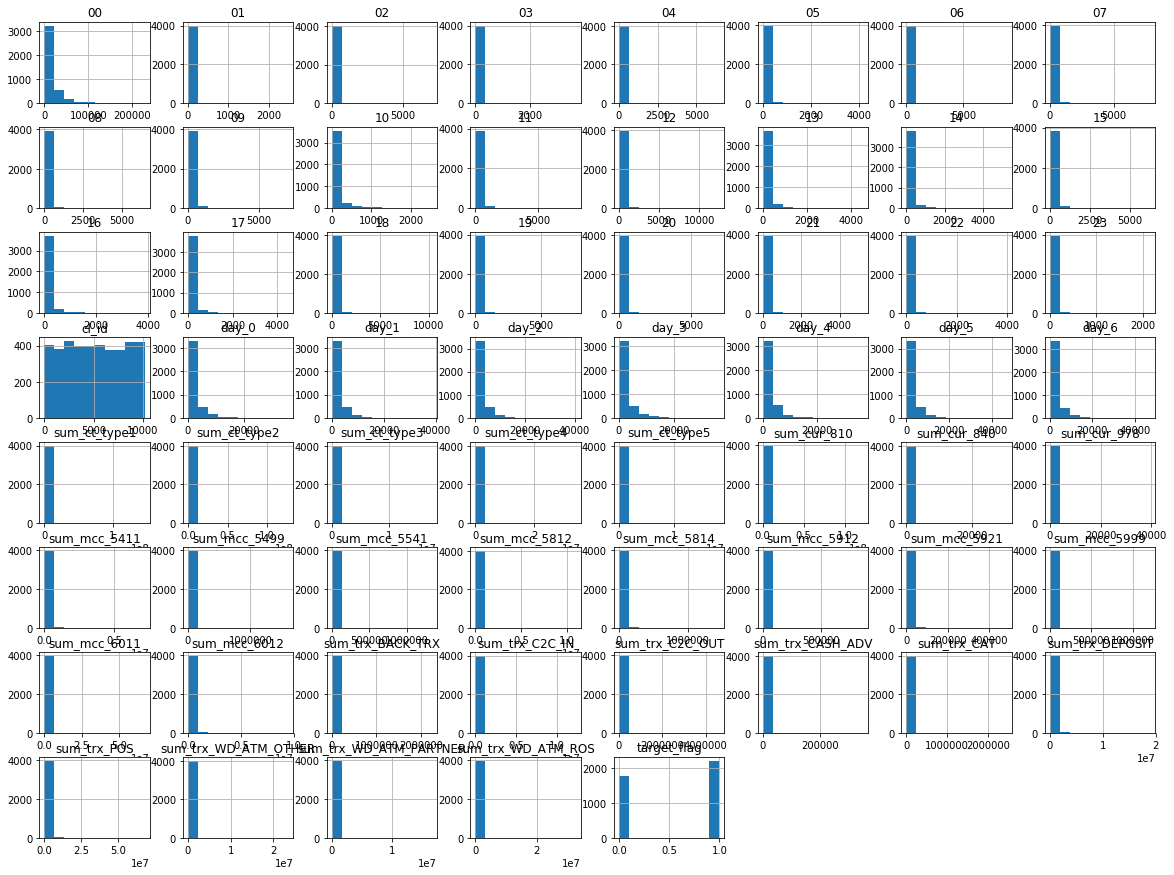

In [32]:
transactions_train.hist(figsize=(20,15));

### Построим тестовую модель на всем наборе фичей

In [33]:
x_train = transactions_train[list(set(transactions_train.columns).difference(['target_flag','channel_type']))]
y_train = transactions_train['target_flag']
x_test = transactions_test[list(set(transactions_train.columns).difference(['target_flag','channel_type']))]
y_test = transactions_test['target_flag']

xgb = xgboost.XGBClassifier(max_depth=7, n_jobs=-1)
xgb.fit(x_train, y_train)
y_train_predict = xgb.predict_proba(x_train)[:, 1]
y_test_predict = xgb.predict_proba(x_test)[:, 1]
roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 2)
roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 2)
print("Train: ", roc_auc_train)
print("Test: ", roc_auc_test)

Train:  0.99
Test:  0.77


In [34]:
xgb = xgboost.XGBClassifier(max_depth=5, n_jobs=-1)
xgb.fit(x_train, y_train)
y_train_predict = xgb.predict_proba(x_train)[:, 1]
y_test_predict = xgb.predict_proba(x_test)[:, 1]
roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 2)
roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 2)
print("Train: ", roc_auc_train)
print("Test: ", roc_auc_test)

Train:  0.93
Test:  0.77


In [35]:
xgb = xgboost.XGBClassifier(max_depth=6, n_jobs=-1)
xgb.fit(x_train, y_train)
y_train_predict = xgb.predict_proba(x_train)[:, 1]
y_test_predict = xgb.predict_proba(x_test)[:, 1]
roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 2)
roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 2)
print("Train: ", roc_auc_train)
print("Test: ", roc_auc_test)

Train:  0.97
Test:  0.78


In [36]:
from sklearn.ensemble import RandomForestClassifier

/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [37]:
cols = list(filter(lambda x: x in x_test.columns, x_train.columns))

In [38]:
clf = RandomForestClassifier(n_estimators = 50, max_depth = 20, random_state=0).fit(x_train[cols].fillna(0), y_train)

In [39]:
y_train_predict = clf.predict_proba(x_train.fillna(0))[:, 1]
y_test_predict = clf.predict_proba(x_test.fillna(0))[:, 1]
roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 2)
roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 2)
print("Train: ", roc_auc_train)
print("Test: ", roc_auc_test)

Train:  1.0
Test:  0.76


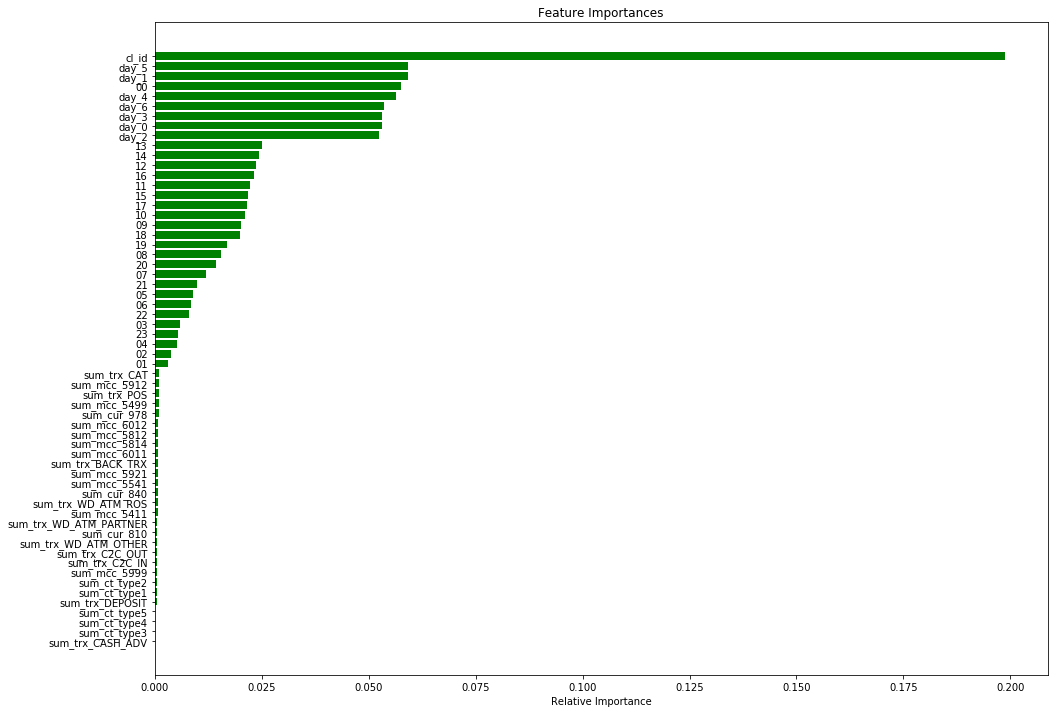

In [40]:
features = x_train.columns
importances = clf.feature_importances_

indeces = np.argsort(importances)

fig, ax = plt.subplots(figsize=(16,12))
plt.title('Feature Importances')
plt.barh(range(len(indeces)), importances[indeces], color='g', align = 'center')
plt.yticks(range(len(indeces)), [features[i] for i in indeces])
plt.xlabel('Relative Importance')
plt.show()

In [41]:
cols = ['day_0','day_6','00'] #,'day_1','day_4','day_5', 'day_2','day_3','11','14','12','13','16','15','10','17','09','18','08','19'] #list(filter(lambda x: x in x_test.columns, x_train.columns))
clf = RandomForestClassifier(n_estimators = 100, max_depth = 5, random_state=0,  n_jobs=-1, oob_score=True).fit(x_train[cols].fillna(0), y_train)
y_train_predict = clf.predict_proba(x_train[cols].fillna(0))[:, 1]
y_test_predict = clf.predict_proba(x_test[cols].fillna(0))[:, 1]
roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 2)
roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 2)
print("Train: ", roc_auc_train)
print("Test: ", roc_auc_test)

Train:  0.72
Test:  0.66


### Агрегирование с помощью Pandas и обучение базовой модели

In [6]:
def get_aggregated_df(df, agg_type, col_to_groupby):
    agg_df = df[['cl_id', col_to_groupby, 'amount']].groupby(['cl_id', col_to_groupby]).agg([agg_type])
    agg_df = agg_df.unstack(fill_value=0)
    agg_df.columns = agg_df.columns.get_level_values(2)

    old_name = agg_df.columns.name
    old_cols = agg_df.columns
    new_cols = [old_name + '_' + agg_type + '_' + str(old_col) for old_col in old_cols]
    agg_df.rename(
        columns={old_col: new_col for old_col, new_col in zip(old_cols, new_cols)}, inplace=True
    )
    return agg_df

In [7]:
raw_df['DATE_'] = raw_df['TRDATETIME'].apply(lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')))

In [8]:
# create transactions dataset for train
transactions_train = raw_df[~raw_df.cl_id.isin(cl_ids_test)].copy()
print("Total transactions in train dataset: ", len(transactions_train))
# create transactions dataset for test
transactions_test = raw_df[raw_df.cl_id.isin(cl_ids_test)].copy()
print("Total transactions in test dataset: ", len(transactions_test))

Total transactions in train dataset:  391422
Total transactions in test dataset:  99091


In [9]:
transactions_train.head()

PERIOD  cl_id   MCC channel_type  currency        TRDATETIME   amount  \
0  01/10/2017      0  5200          NaN       810  21OCT17:00:00:00   5023.0   
1  01/10/2017      0  6011          NaN       810  12OCT17:12:24:07  20000.0   
2  01/12/2017      0  5921          NaN       810  05DEC17:00:00:00    767.0   
3  01/10/2017      0  5411          NaN       810  21OCT17:00:00:00   2031.0   
4  01/10/2017      0  6012          NaN       810  24OCT17:13:14:24  36562.0   

  trx_category  target_flag  target_sum               DATE_  
0          POS            0         0.0 2017-10-21 00:00:00  
1      DEPOSIT            0         0.0 2017-10-12 12:24:07  
2          POS            0         0.0 2017-12-05 00:00:00  
3          POS            0         0.0 2017-10-21 00:00:00  
4      C2C_OUT            0         0.0 2017-10-24 13:14:24

In [10]:
transactions_train[transactions_train['target_flag']==1]

PERIOD  cl_id   MCC channel_type  currency        TRDATETIME  \
109     01/06/2017      5  5944          NaN       810  18JUN17:00:00:00   
110     01/06/2017      5  6012          NaN       810  14JUN17:00:00:00   
111     01/04/2017      5  5621          NaN       810  06APR17:00:00:00   
112     01/06/2017      5  5691          NaN       810  17JUN17:00:00:00   
113     01/04/2017      5  5499          NaN       810  25APR17:00:00:00   
114     01/05/2017      5  5411          NaN       810  18MAY17:00:00:00   
115     01/05/2017      5  6012          NaN       810  16MAY17:00:00:00   
116     01/04/2017      5  5411          NaN       810  27APR17:00:00:00   
117     01/05/2017      5  5411          NaN       810  19MAY17:00:00:00   
118     01/06/2017      5  4112          NaN       810  16JUN17:00:00:00   
119     01/06/2017      5  5735          NaN       810  02JUN17:00:00:00   
120     01/05/2017      5  5411          NaN       978  06MAY17:00:00:00   
121     01/05/2017      5  5411          NaN       810  29MAY17:00:00:00   
122     01/04/2017      5  5995          NaN       810  20APR17:00:00:00   
123     01/05/2017      5  5499          NaN       810  13MAY17:00:00:00   
124     01/06/2017      5  5995          NaN       810  05JUN17:00:00:00   
125     01/06/2017      5  5331          NaN       810  08JUN17:00:00:00   
126     01/04/2017      5  5411          NaN       810  01APR17:00:00:00   
127     01/04/2017      5  6011          NaN       810  06APR17:17:03:05   
128     01/05/2017      5  7230          NaN       810  18MAY17:00:00:00   
129     01/03/2017      5  7922          NaN       810  21MAR17:00:00:00   
130     01/04/2017      5  5411          NaN       810  13APR17:00:00:00   
131     01/04/2017      5  5499          NaN       810  21APR17:00:00:00   
132     01/05/2017      5  6012          NaN       810  18MAY17:00:00:00   
133     01/04/2017      5  5977          NaN       810  27APR17:00:00:00   
134     01/06/2017      5  5691          NaN       810  17JUN17:00:00:00   
135     01/03/2017      5  5411          NaN       810  20MAR17:00:00:00   
136     01/04/2017      5  5977          NaN       810  21APR17:00:00:00   
137     01/06/2017      5  5691          NaN       810  18JUN17:00:00:00   
138     01/03/2017      5  5651          NaN       810  19MAR17:00:00:00   
...            ...    ...   ...          ...       ...               ...   
490437  01/07/2017  10162  5912        type1       810  26JUL17:00:00:00   
490438  01/07/2017  10162  5411        type1       810  02JUL17:00:00:00   
490441  01/08/2017  10162  5941        type1       810  01AUG17:00:00:00   
490444  01/12/2016  10167  6011        type1       810  21DEC16:18:23:44   
490448  01/12/2016  10167  5812        type1       810  20DEC16:00:00:00   
490450  01/12/2016  10167  5912        type1       810  16DEC16:00:00:00   
490452  01/12/2016  10167  5814        type1       810  14DEC16:00:00:00   
490454  01/12/2016  10167  5541        type1       810  15DEC16:00:00:00   
490455  01/12/2016  10167  5681        type1       810  11DEC16:00:00:00   
490457  01/12/2016  10167  6011        type1       810  14DEC16:20:18:41   
490458  01/12/2016  10167  6011        type1       810  07DEC16:13:55:28   
490460  01/12/2016  10167  5541        type1       810  08DEC16:00:00:00   
490461  01/12/2016  10167  6011        type1       810  08DEC16:22:20:00   
490463  01/12/2016  10167  4784        type1       810  06DEC16:00:00:00   
490464  01/03/2017  10167  4112        type1       810  06MAR17:00:00:00   
490465  01/03/2017  10167  6011        type1       810  06MAR17:20:10:21   
490466  01/02/2017  10193  6011        type1       810  22FEB17:10:52:03   
490467  01/02/2017  10193  6011        type1       810  11FEB17:14:17:42   
490468  01/12/2016  10193  5712        type1       810  11DEC16:00:00:00   
490469  01/02/2017  10193  6011        type1       810  11FEB17:14:16:47   
490470  01/01/2017  10193  6011        type1       810  19JA

In [11]:
transactions_train[transactions_train['cl_id']==5].groupby(['cl_id','DATE_','MCC','trx_category']).agg(['count'])

PERIOD channel_type currency  \
                                               count        count    count   
cl_id DATE_               MCC  trx_category                                  
5     2017-03-18 00:00:00 5651 POS                 1            0        1   
                          5813 POS                 1            0        1   
      2017-03-19 00:00:00 5651 BACK_TRX            1            0        1   
                          5691 POS                 1            0        1   
      2017-03-20 00:00:00 4722 POS                 1            0        1   
                          5411 POS                 1            0        1   
      2017-03-21 00:00:00 5411 POS                 1            0        1   
                          7922 POS                 1            0        1   
      2017-03-24 00:00:00 5691 POS                 1            0        1   
                          5812 POS                 1            0        1   
                          5977 POS                 1            0        1   
      2017-03-25 00:00:00 6011 WD_ATM_PARTNER      1            0        1   
      2017-03-27 00:00:00 4814 POS                 1            0        1   
      2017-03-29 00:00:00 4131 POS                 1            0        1   
      2017-03-29 13:56:00 6011 WD_ATM_ROS          1            0        1   
      2017-03-31 00:00:00 5411 POS                 1            0        1   
                          9222 POS                 1            0        1   
      2017-04-01 00:00:00 5411 POS                 1            0        1   
      2017-04-02 00:00:00 5411 POS                 1            0        1   
                          8011 POS                 1            0        1   
      2017-04-05 00:00:00 5977 POS                 1            0        1   
      2017-04-06 00:00:00 5411 POS                 1            0        1   
                          5621 POS                 1            0        1   
                          5735 POS                 1            0        1   
                          7991 POS                 1            0        1   
      2017-04-06 17:02:19 6011 DEPOSIT             1            0        1   
      2017-04-06 17:03:05 6011 DEPOSIT             1            0        1   
      2017-04-07 00:00:00 5812 POS                 1            0        1   
      2017-04-08 00:00:00 5691 POS                 1            0        1   
                          5977 POS                 1            0        1   
...                                              ...          ...      ...   
      2017-05-27 00:00:00 5411 POS                 1            0        1   
      2017-05-28 00:00:00 7011 POS                 1            0        1   
      2017-05-29 00:00:00 5411 POS                 1            0        1   
                          6011 WD_ATM_PARTNER      1            0        1   
      2017-06-01 00:00:00 4814 POS                 1            0        1   
      2017-06-02 00:00:00 5411 POS                 1            0        1   
                          5735 POS                 1            0        1   
      2017-06-03 00:00:00 5499 POS                 2            0        2   
                          6011 WD_ATM_OTHER        2            0        2   
      2017-06-05 00:00:00 5995 POS                 2            0        2   
      2017-06-05 11:49:36 6011 WD_ATM_ROS          1            0        1   
      2017-06-06 00:00:00 7922 POS                 1            0        1   
      2017-06-06 19:34:15 6011 DEPOSIT             1            0        1   
      2017-06-06 19:34:58 6011 DEPOSIT             1            0        1   
      2017-06-08 00:00:00 5331 POS                 1            0        1   
                          5691 POS                 1            0        1   
                          5941 POS                 1            0        1   
      2017-06-09 00:00:00 5411 POS                 1            0   

In [12]:
testdf = transactions_train[transactions_train['cl_id']==5].groupby(['cl_id']).fillna(0).reset_index()

In [13]:
print(min(testdf['DATE_']))
print(max(testdf['DATE_']))
print(testdf['DATE_'].count())
print(testdf[testdf['DATE_'] > max(testdf['DATE_']) - dateutil.relativedelta.relativedelta(months=12)]['DATE_'].count())
print(testdf[testdf['DATE_'] > max(testdf['DATE_']) - dateutil.relativedelta.relativedelta(months=6)]['DATE_'].count())
print(testdf[testdf['DATE_'] > max(testdf['DATE_']) - dateutil.relativedelta.relativedelta(months=3)]['DATE_'].count())
print(testdf[testdf['DATE_'] > max(testdf['DATE_']) - dateutil.relativedelta.relativedelta(months=2)]['DATE_'].count())
print(testdf[testdf['DATE_'] > max(testdf['DATE_']) - dateutil.relativedelta.relativedelta(months=1)]['DATE_'].count())
print(testdf[testdf['DATE_'] > max(testdf['DATE_']) - dateutil.relativedelta.relativedelta(weeks=2)]['DATE_'].count())
print(testdf[testdf['DATE_'] > max(testdf['DATE_']) - dateutil.relativedelta.relativedelta(weeks=1)]['DATE_'].count())

2017-03-18 00:00:00
2017-06-18 00:00:00
142
142
142
140
100
44
30
18


In [60]:
def create_new_features_df(cl_id_df):
    index=range(0,1)
    columns=['last12m','last6m','last2m','last1m','last2w','last1w']
    ret_df = pd.DataFrame(index=index, columns=columns)
    ret_df['last12m'] = cl_id_df[cl_id_df['DATE_'] > max(cl_id_df['DATE_']) - dateutil.relativedelta.relativedelta(months=12)]['DATE_'].count()/365
    ret_df['last6m'] = cl_id_df[cl_id_df['DATE_'] > max(cl_id_df['DATE_']) - dateutil.relativedelta.relativedelta(months=6)]['DATE_'].count()/183
    ret_df['last2m'] = cl_id_df[cl_id_df['DATE_'] > max(cl_id_df['DATE_']) - dateutil.relativedelta.relativedelta(months=2)]['DATE_'].count()/61
    ret_df['last1m'] = cl_id_df[cl_id_df['DATE_'] > max(cl_id_df['DATE_']) - dateutil.relativedelta.relativedelta(months=1)]['DATE_'].count()/30
    ret_df['last2w'] = cl_id_df[cl_id_df['DATE_'] > max(cl_id_df['DATE_']) - dateutil.relativedelta.relativedelta(weeks=2)]['DATE_'].count()/14
    ret_df['last1w'] = cl_id_df[cl_id_df['DATE_'] > max(cl_id_df['DATE_']) - dateutil.relativedelta.relativedelta(weeks=1)]['DATE_'].count()/7
    
    ret_df['last12mPOS'] = cl_id_df[(cl_id_df['trx_category'] == 'POS') & (cl_id_df['DATE_'] > max(cl_id_df['DATE_']) - dateutil.relativedelta.relativedelta(months=12))]['DATE_'].count()/365
    ret_df['last6mPOS'] = cl_id_df[(cl_id_df['trx_category'] == 'POS') & (cl_id_df['DATE_'] > max(cl_id_df['DATE_']) - dateutil.relativedelta.relativedelta(months=6))]['DATE_'].count()/183
    ret_df['last2mPOS'] = cl_id_df[(cl_id_df['trx_category'] == 'POS') & (cl_id_df['DATE_'] > max(cl_id_df['DATE_']) - dateutil.relativedelta.relativedelta(months=2))]['DATE_'].count()/61
    ret_df['last1mPOS'] = cl_id_df[(cl_id_df['trx_category'] == 'POS') & (cl_id_df['DATE_'] > max(cl_id_df['DATE_']) - dateutil.relativedelta.relativedelta(months=1))]['DATE_'].count()/30
    ret_df['last2wPOS'] = cl_id_df[(cl_id_df['trx_category'] == 'POS') & (cl_id_df['DATE_'] > max(cl_id_df['DATE_']) - dateutil.relativedelta.relativedelta(weeks=2))]['DATE_'].count()/14
    ret_df['last1wPOS'] = cl_id_df[(cl_id_df['trx_category'] == 'POS') & (cl_id_df['DATE_'] > max(cl_id_df['DATE_']) - dateutil.relativedelta.relativedelta(weeks=1))]['DATE_'].count()/7
    
    ret_df['last12mDEP'] = cl_id_df[(cl_id_df['trx_category'] == 'DEPOSIT') & (cl_id_df['DATE_'] > max(cl_id_df['DATE_']) - dateutil.relativedelta.relativedelta(months=12))]['DATE_'].count()/365
    ret_df['last6mDEP'] = cl_id_df[(cl_id_df['trx_category'] == 'DEPOSIT') & (cl_id_df['DATE_'] > max(cl_id_df['DATE_']) - dateutil.relativedelta.relativedelta(months=6))]['DATE_'].count()/183
    ret_df['last2mDEP'] = cl_id_df[(cl_id_df['trx_category'] == 'DEPOSIT') & (cl_id_df['DATE_'] > max(cl_id_df['DATE_']) - dateutil.relativedelta.relativedelta(months=2))]['DATE_'].count()/61
    ret_df['last1mDEP'] = cl_id_df[(cl_id_df['trx_category'] == 'DEPOSIT') & (cl_id_df['DATE_'] > max(cl_id_df['DATE_']) - dateutil.relativedelta.relativedelta(months=1))]['DATE_'].count()/30
    ret_df['last2wDEP'] = cl_id_df[(cl_id_df['trx_category'] == 'DEPOSIT') & (cl_id_df['DATE_'] > max(cl_id_df['DATE_']) - dateutil.relativedelta.relativedelta(weeks=2))]['DATE_'].count()/14
    ret_df['last1wDEP'] = cl_id_df[(cl_id_df['trx_category'] == 'DEPOSIT') & (cl_id_df['DATE_'] > max(cl_id_df['DATE_']) - dateutil.relativedelta.relativedelta(weeks=1))]['DATE_'].count()/7
    return ret_df

In [61]:
create_new_features_df(testdf)

last12m    last6m    last2m    last1m    last2w    last1w  last12mPOS  \
0  0.389041  0.775956  1.639344  1.466667  2.142857  2.571429     0.30411   

   last6mPOS  last2mPOS  last1mPOS  last2wPOS  last1wPOS  last12mDEP  \
0   0.606557   1.262295        1.2   1.785714   2.285714    0.010959   

   last6mDEP  last2mDEP  last1mDEP  last2wDEP  last1wDEP  
0   0.021858   0.032787   0.066667   0.142857        0.0

In [62]:
train_cl_stat = transactions_train.groupby(['cl_id']).apply(create_new_features_df)
train_cl_stat = train_cl_stat.fillna(0).reset_index().drop(['level_1','cl_id'],axis=1)

In [63]:
train_cl_stat.head()

last12m    last6m    last2m    last1m    last2w    last1w  last12mPOS  \
0  0.013699  0.027322  0.081967  0.033333  0.071429  0.142857    0.008219   
1  0.284932  0.568306  1.491803  2.000000  1.000000  1.000000    0.276712   
2  0.389041  0.775956  1.639344  1.466667  2.142857  2.571429    0.304110   
3  0.106849  0.213115  0.360656  0.533333  0.500000  0.428571    0.079452   
4  1.268493  2.530055  5.655738  4.500000  3.785714  3.142857    1.024658   

   last6mPOS  last2mPOS  last1mPOS  last2wPOS  last1wPOS  last12mDEP  \
0   0.016393   0.049180   0.033333   0.071429   0.142857    0.002740   
1   0.551913   1.459016   1.933333   1.000000   1.000000    0.005479   
2   0.606557   1.262295   1.200000   1.785714   2.285714    0.010959   
3   0.158470   0.278689   0.433333   0.357143   0.285714    0.002740   
4   2.043716   4.639344   4.000000   3.571429   3.142857    0.065753   

   last6mDEP  last2mDEP  last1mDEP  last2wDEP  last1wDEP  
0   0.005464   0.016393   0.000000   0.000000        0.0  
1   0.010929   0.032787   0.066667   0.000000        0.0  
2   0.021858   0.032787   0.066667   0.142857        0.0  
3   0.005464   0.000000   0.000000   0.000000        0.0  
4   0.131148   0.360656   0.100000   0.071429        0.0

In [64]:
df_train_mcc = pd.merge(
    get_aggregated_df(transactions_train, agg_type='mean', col_to_groupby='MCC'),
    get_aggregated_df(transactions_train, agg_type='sum', col_to_groupby='MCC'),
    left_index=True,
    right_index=True,
)

df_train_trx_category = pd.merge(
    get_aggregated_df(transactions_train, agg_type='mean', col_to_groupby='trx_category'),
    get_aggregated_df(transactions_train, agg_type='sum', col_to_groupby='trx_category'),
    #get_aggregated_df(transactions_train, agg_type='last', col_to_groupby='trx_category'),
    left_index=True,
    right_index=True,
)

df_train = pd.merge(
    df_train_mcc,
    df_train_trx_category,
    left_index=True,
    right_index=True,
)

df_train = pd.merge(
    df_train,
    train_cl_stat,
    left_index=True,
    right_index=True,
)

In [65]:
df_train.head()

MCC_mean_742  MCC_mean_763  MCC_mean_780  MCC_mean_1520  MCC_mean_1711  \
0            0.0           0.0           0.0            0.0            0.0   
1            0.0           0.0           0.0            0.0            0.0   
5            0.0           0.0           0.0            0.0            0.0   
9            0.0           0.0           0.0            0.0            0.0   
10           0.0           0.0           0.0            0.0            0.0   

    MCC_mean_1731  MCC_mean_1750  MCC_mean_1799  MCC_mean_2741  MCC_mean_2842  \
0             0.0            0.0            0.0            0.0            0.0   
1             0.0            0.0            0.0            0.0            0.0   
5             0.0            0.0            0.0            0.0            0.0   
9             0.0            0.0            0.0            0.0            0.0   
10            0.0            0.0            0.0            0.0            0.0   

      ...      last2mPOS  last1mPOS  last2wPOS  last1wPOS  last12mDEP  \
0     ...       0.049180   0.033333   0.071429   0.142857    0.002740   
1     ...       1.459016   1.933333   1.000000   1.000000    0.005479   
5     ...       1.967213   1.500000   0.357143   0.428571    0.027397   
9     ...       0.688525   0.466667   1.000000   1.571429    0.021918   
10    ...       0.393443   0.300000   0.285714   0.571429    0.005479   

    last6mDEP  last2mDEP  last1mDEP  last2wDEP  last1wDEP  
0    0.005464   0.016393   0.000000   0.000000   0.000000  
1    0.010929   0.032787   0.066667   0.000000   0.000000  
5    0.054645   0.098361   0.133333   0.000000   0.000000  
9    0.043716   0.098361   0.033333   0.071429   0.142857  
10   0.010929   0.000000   0.000000   0.000000   0.000000  

[5 rows x 714 columns]

In [66]:
df_targets = raw_df[['cl_id', 'target_flag']].drop_duplicates().copy()
df_targets.index = df_targets['cl_id']
df_targets = df_targets.drop('cl_id', axis=1)
df_targets.head()

target_flag
cl_id             
0                0
1                0
5                1
9                0
10               0

In [67]:
df_train = pd.merge(
    df_train,
    df_targets,
    left_index=True,
    right_index=True,
    how='inner'
)

In [68]:
df_test_mcc = pd.merge(
    get_aggregated_df(transactions_test, agg_type='mean', col_to_groupby='MCC'),
    get_aggregated_df(transactions_test, agg_type='sum', col_to_groupby='MCC'),
    #get_aggregated_df(transactions_test, agg_type='last', col_to_groupby='MCC'),
    left_index=True,
    right_index=True,
)

df_test_trx_category = pd.merge(
    get_aggregated_df(transactions_test, agg_type='mean', col_to_groupby='trx_category'),
    get_aggregated_df(transactions_test, agg_type='sum', col_to_groupby='trx_category'),
    #get_aggregated_df(transactions_test, agg_type='last', col_to_groupby='trx_category'),
    left_index=True,
    right_index=True,
)

df_test = pd.merge(
    df_test_mcc,
    df_test_trx_category,
    left_index=True,
    right_index=True,
)

test_cl_stat = transactions_test.groupby(['cl_id']).apply(create_new_features_df)
test_cl_stat = test_cl_stat.fillna(0).reset_index().drop(['level_1','cl_id'],axis=1)

df_test = pd.merge(
    test_cl_stat,
    df_test,
    left_index=True,
    right_index=True,
)

In [69]:
df_test = pd.merge(
    df_test,
    df_targets,
    left_index=True,
    right_index=True,
    how='inner'
)

In [70]:
X_test = df_test.drop(['target_flag'], axis=1)
y_test = df_test['target_flag']
X_train = df_train.drop(['target_flag'], axis=1)
y_train = df_train['target_flag']

In [71]:
X_train.head()

MCC_mean_742  MCC_mean_763  MCC_mean_780  MCC_mean_1520  MCC_mean_1711  \
0            0.0           0.0           0.0            0.0            0.0   
1            0.0           0.0           0.0            0.0            0.0   
5            0.0           0.0           0.0            0.0            0.0   
9            0.0           0.0           0.0            0.0            0.0   
10           0.0           0.0           0.0            0.0            0.0   

    MCC_mean_1731  MCC_mean_1750  MCC_mean_1799  MCC_mean_2741  MCC_mean_2842  \
0             0.0            0.0            0.0            0.0            0.0   
1             0.0            0.0            0.0            0.0            0.0   
5             0.0            0.0            0.0            0.0            0.0   
9             0.0            0.0            0.0            0.0            0.0   
10            0.0            0.0            0.0            0.0            0.0   

      ...      last2mPOS  last1mPOS  last2wPOS  last1wPOS  last12mDEP  \
0     ...       0.049180   0.033333   0.071429   0.142857    0.002740   
1     ...       1.459016   1.933333   1.000000   1.000000    0.005479   
5     ...       1.967213   1.500000   0.357143   0.428571    0.027397   
9     ...       0.688525   0.466667   1.000000   1.571429    0.021918   
10    ...       0.393443   0.300000   0.285714   0.571429    0.005479   

    last6mDEP  last2mDEP  last1mDEP  last2wDEP  last1wDEP  
0    0.005464   0.016393   0.000000   0.000000   0.000000  
1    0.010929   0.032787   0.066667   0.000000   0.000000  
5    0.054645   0.098361   0.133333   0.000000   0.000000  
9    0.043716   0.098361   0.033333   0.071429   0.142857  
10   0.010929   0.000000   0.000000   0.000000   0.000000  

[5 rows x 714 columns]

In [72]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve

In [73]:
cols = list(filter(lambda x: x in X_test.columns, X_train.columns))

In [74]:
clf = RandomForestClassifier(n_estimators=300, max_depth=30, random_state=0).fit(X_train[cols], y_train)

In [75]:
y_train_predict = clf.predict_proba(X_train[cols])[:, 1]


roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 2)
print("Train: ", roc_auc_train)

Train:  1.0


In [76]:
y_test_predict = clf.predict_proba(X_test[cols])[:, 1]


roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 2)
print("Test: ", roc_auc_test)

Test:  0.73


In [100]:
from sklearn.feature_selection import chi2 
from sklearn.feature_selection import SelectKBest 
select = SelectKBest(chi2, k=50) 
X_train_new = select.fit_transform(X_train[cols], y_train)

In [105]:
cols_new = [c[1] for c in zip(select.get_support(),cols) if c[0]]
print(cols_new)

['MCC_mean_3026', 'MCC_mean_3136', 'MCC_mean_4722', 'MCC_mean_5309', 'MCC_mean_5499', 'MCC_mean_5691', 'MCC_mean_5941', 'MCC_mean_5947', 'MCC_mean_5971', 'MCC_mean_7011', 'MCC_mean_7399', 'MCC_sum_3026', 'MCC_sum_3136', 'MCC_sum_4511', 'MCC_sum_4812', 'MCC_sum_5211', 'MCC_sum_5309', 'MCC_sum_5311', 'MCC_sum_5411', 'MCC_sum_5499', 'MCC_sum_5661', 'MCC_sum_5691', 'MCC_sum_5812', 'MCC_sum_5814', 'MCC_sum_5912', 'MCC_sum_5921', 'MCC_sum_5941', 'MCC_sum_5942', 'MCC_sum_5947', 'MCC_sum_5971', 'MCC_sum_5999', 'MCC_sum_6010', 'MCC_sum_6011', 'MCC_sum_6051', 'MCC_sum_6300', 'MCC_sum_7011', 'MCC_sum_7298', 'MCC_sum_7395', 'MCC_sum_7399', 'MCC_sum_8099', 'trx_category_mean_CASH_ADV', 'trx_category_mean_WD_ATM_OTHER', 'trx_category_sum_BACK_TRX', 'trx_category_sum_C2C_IN', 'trx_category_sum_CASH_ADV', 'trx_category_sum_CAT', 'trx_category_sum_DEPOSIT', 'trx_category_sum_POS', 'trx_category_sum_WD_ATM_OTHER', 'trx_category_sum_WD_ATM_PARTNER']


In [106]:
clf = RandomForestClassifier(n_estimators=300, max_depth=30, random_state=0).fit(X_train[cols_new], y_train)
y_train_predict = clf.predict_proba(X_train[cols_new])[:, 1]


roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 2)
print("Train: ", roc_auc_train)

Train:  1.0


In [107]:
y_test_predict = clf.predict_proba(X_test[cols_new])[:, 1]


roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 2)
print("Test: ", roc_auc_test)

Test:  0.7


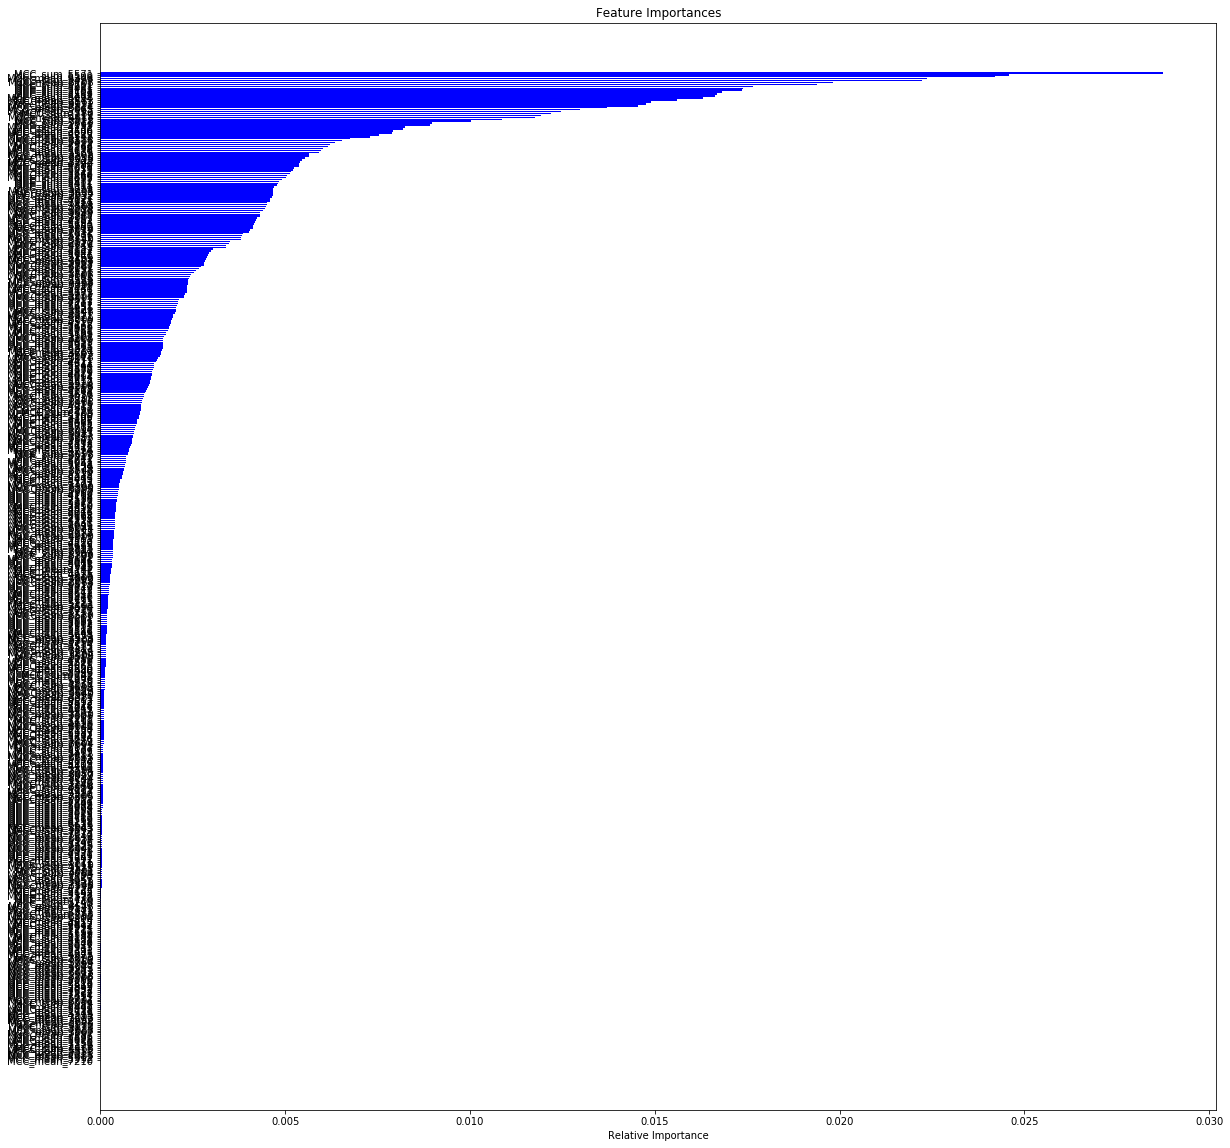

In [44]:
features = X_train.columns
importances = clf.feature_importances_

indices = np.argsort(importances)

fig, ax = plt.subplots(figsize=(20,20))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

/home/truename/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/truename/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/truename/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/home/truename/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **pas

CPU times: user 23.5 s, sys: 96 ms, total: 23.6 s
Wall time: 23.6 s


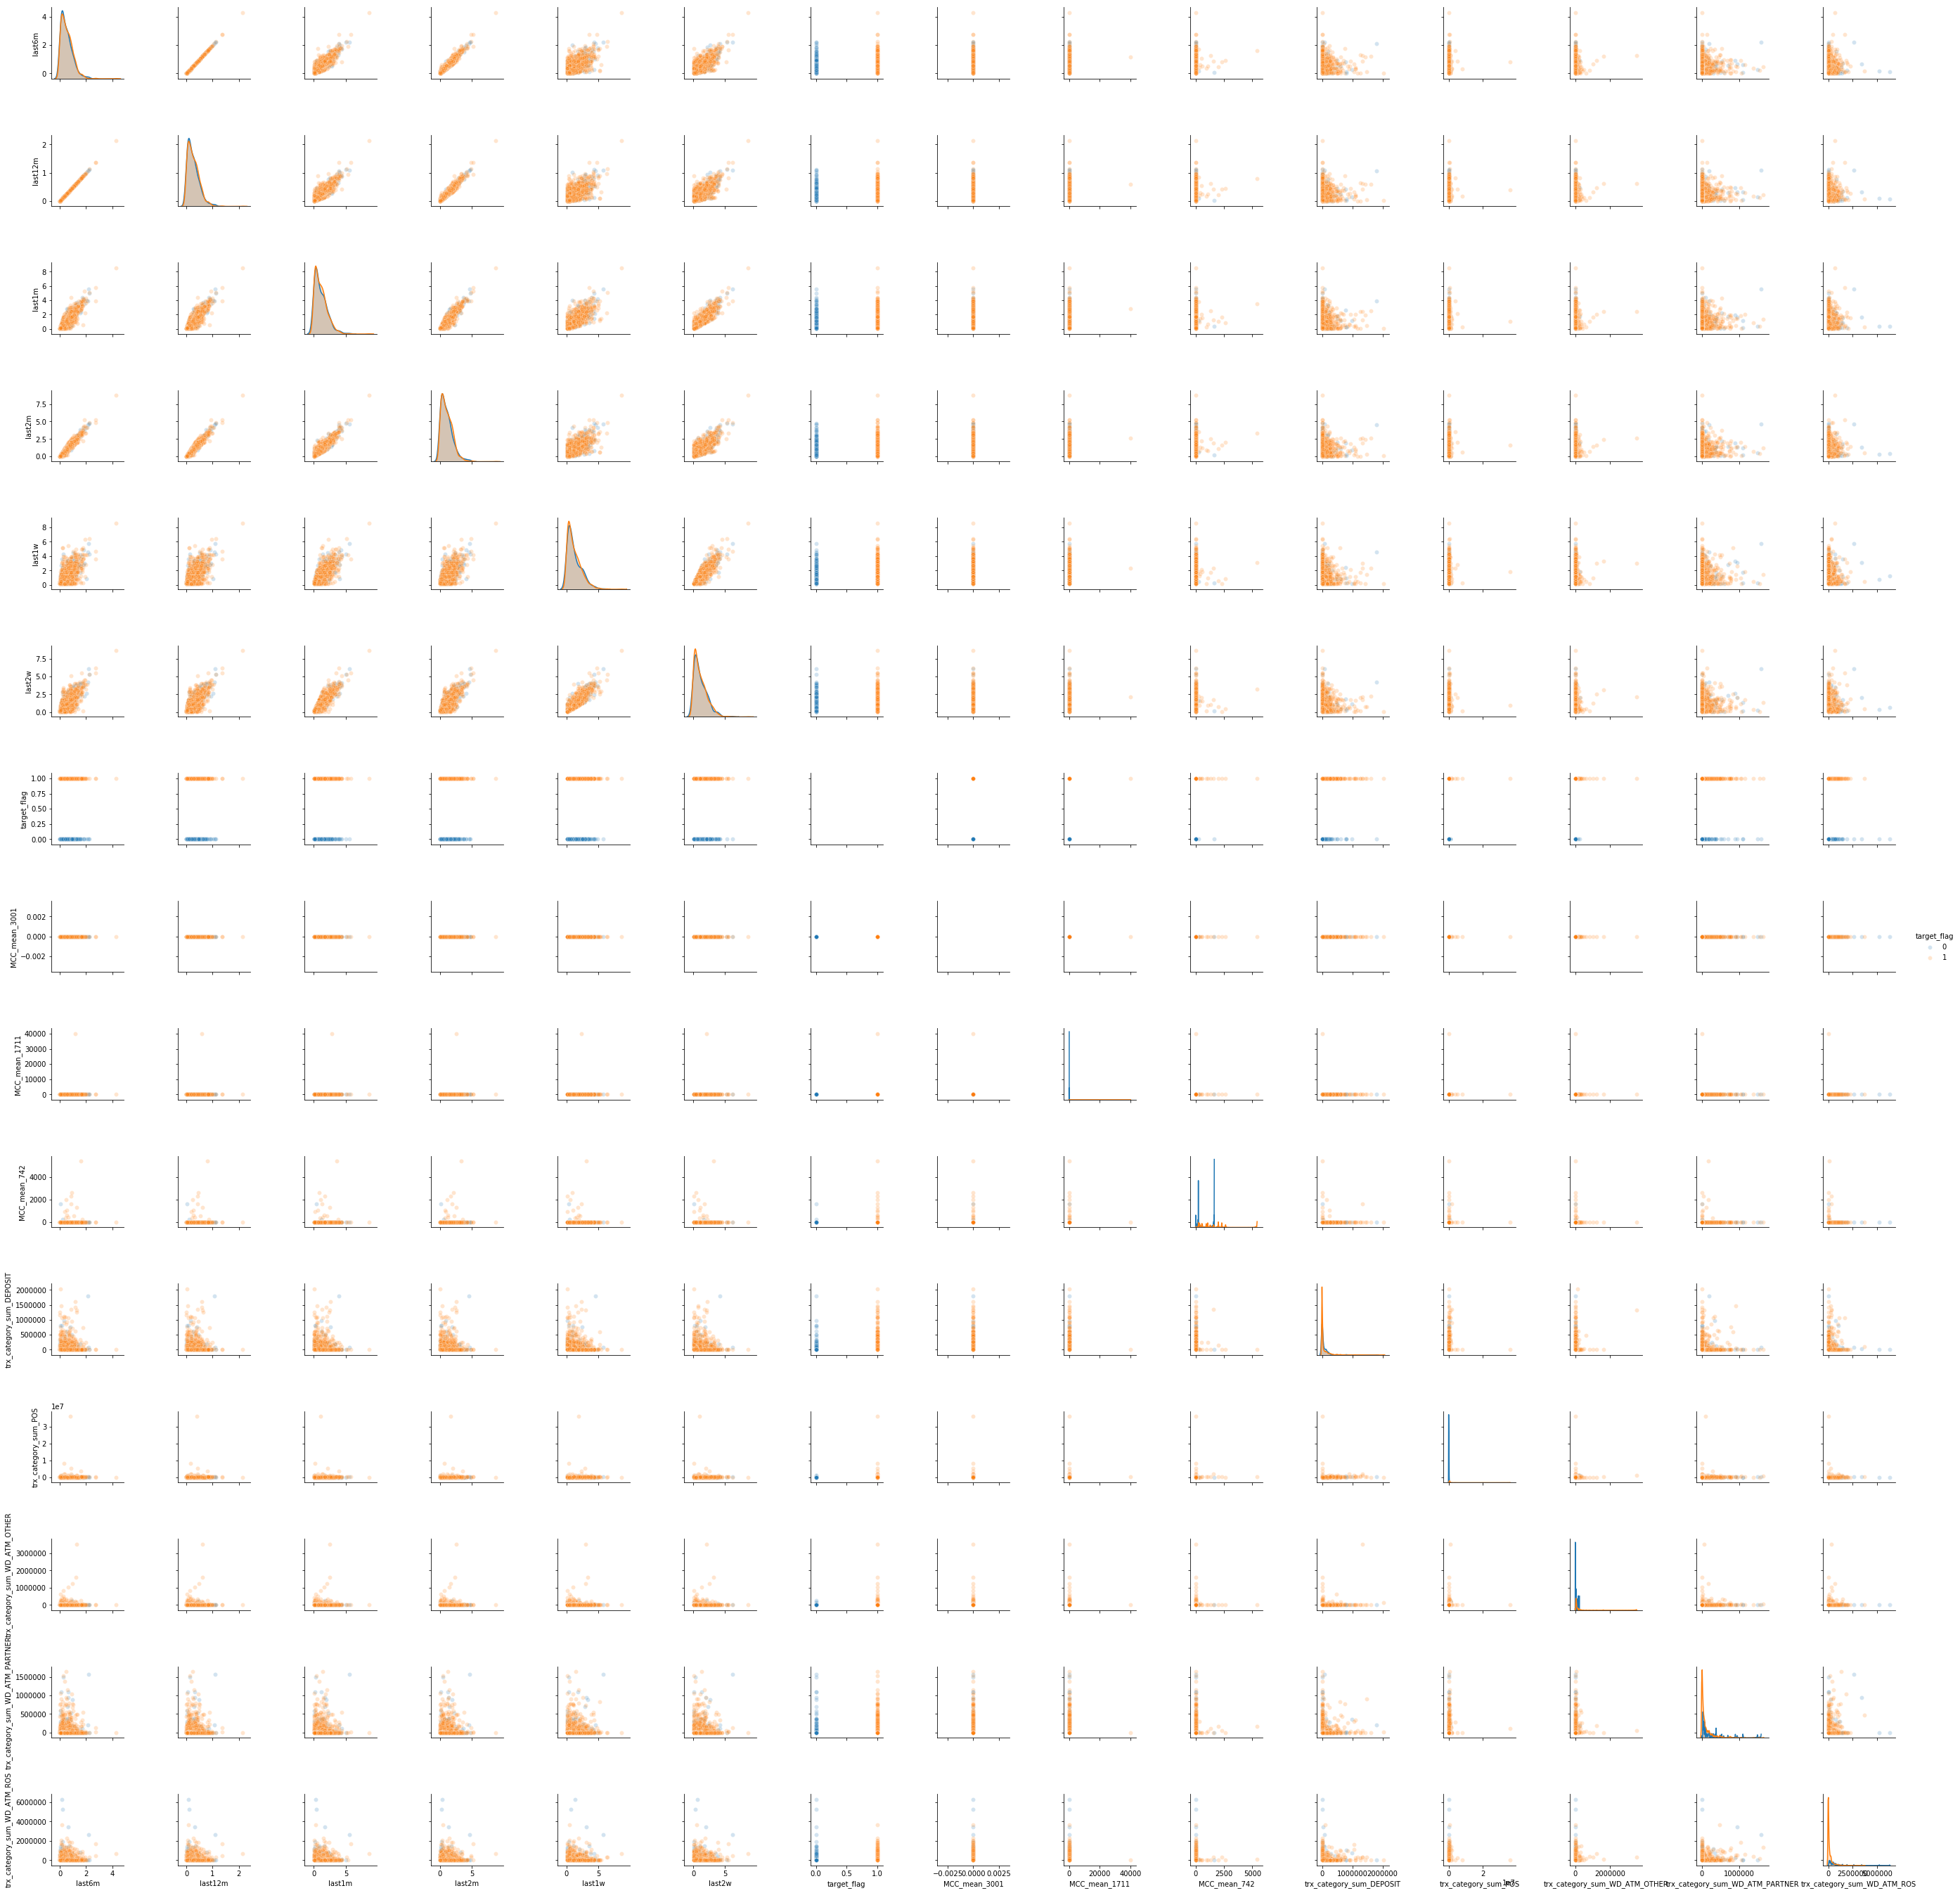

In [114]:
%%time
sns.pairplot(data=df_train[['last6m','last12m','last1m','last2m','last1w','last2w','target_flag','MCC_mean_3001','MCC_mean_1711','MCC_mean_742',
                           'trx_category_sum_DEPOSIT','trx_category_sum_POS','trx_category_sum_WD_ATM_OTHER','trx_category_sum_WD_ATM_PARTNER','trx_category_sum_WD_ATM_ROS']],plot_kws={'alpha':0.2},hue='target_flag');

/home/truename/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/truename/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/truename/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/home/truename/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **pas

CPU times: user 18.7 s, sys: 80 ms, total: 18.7 s
Wall time: 18.7 s


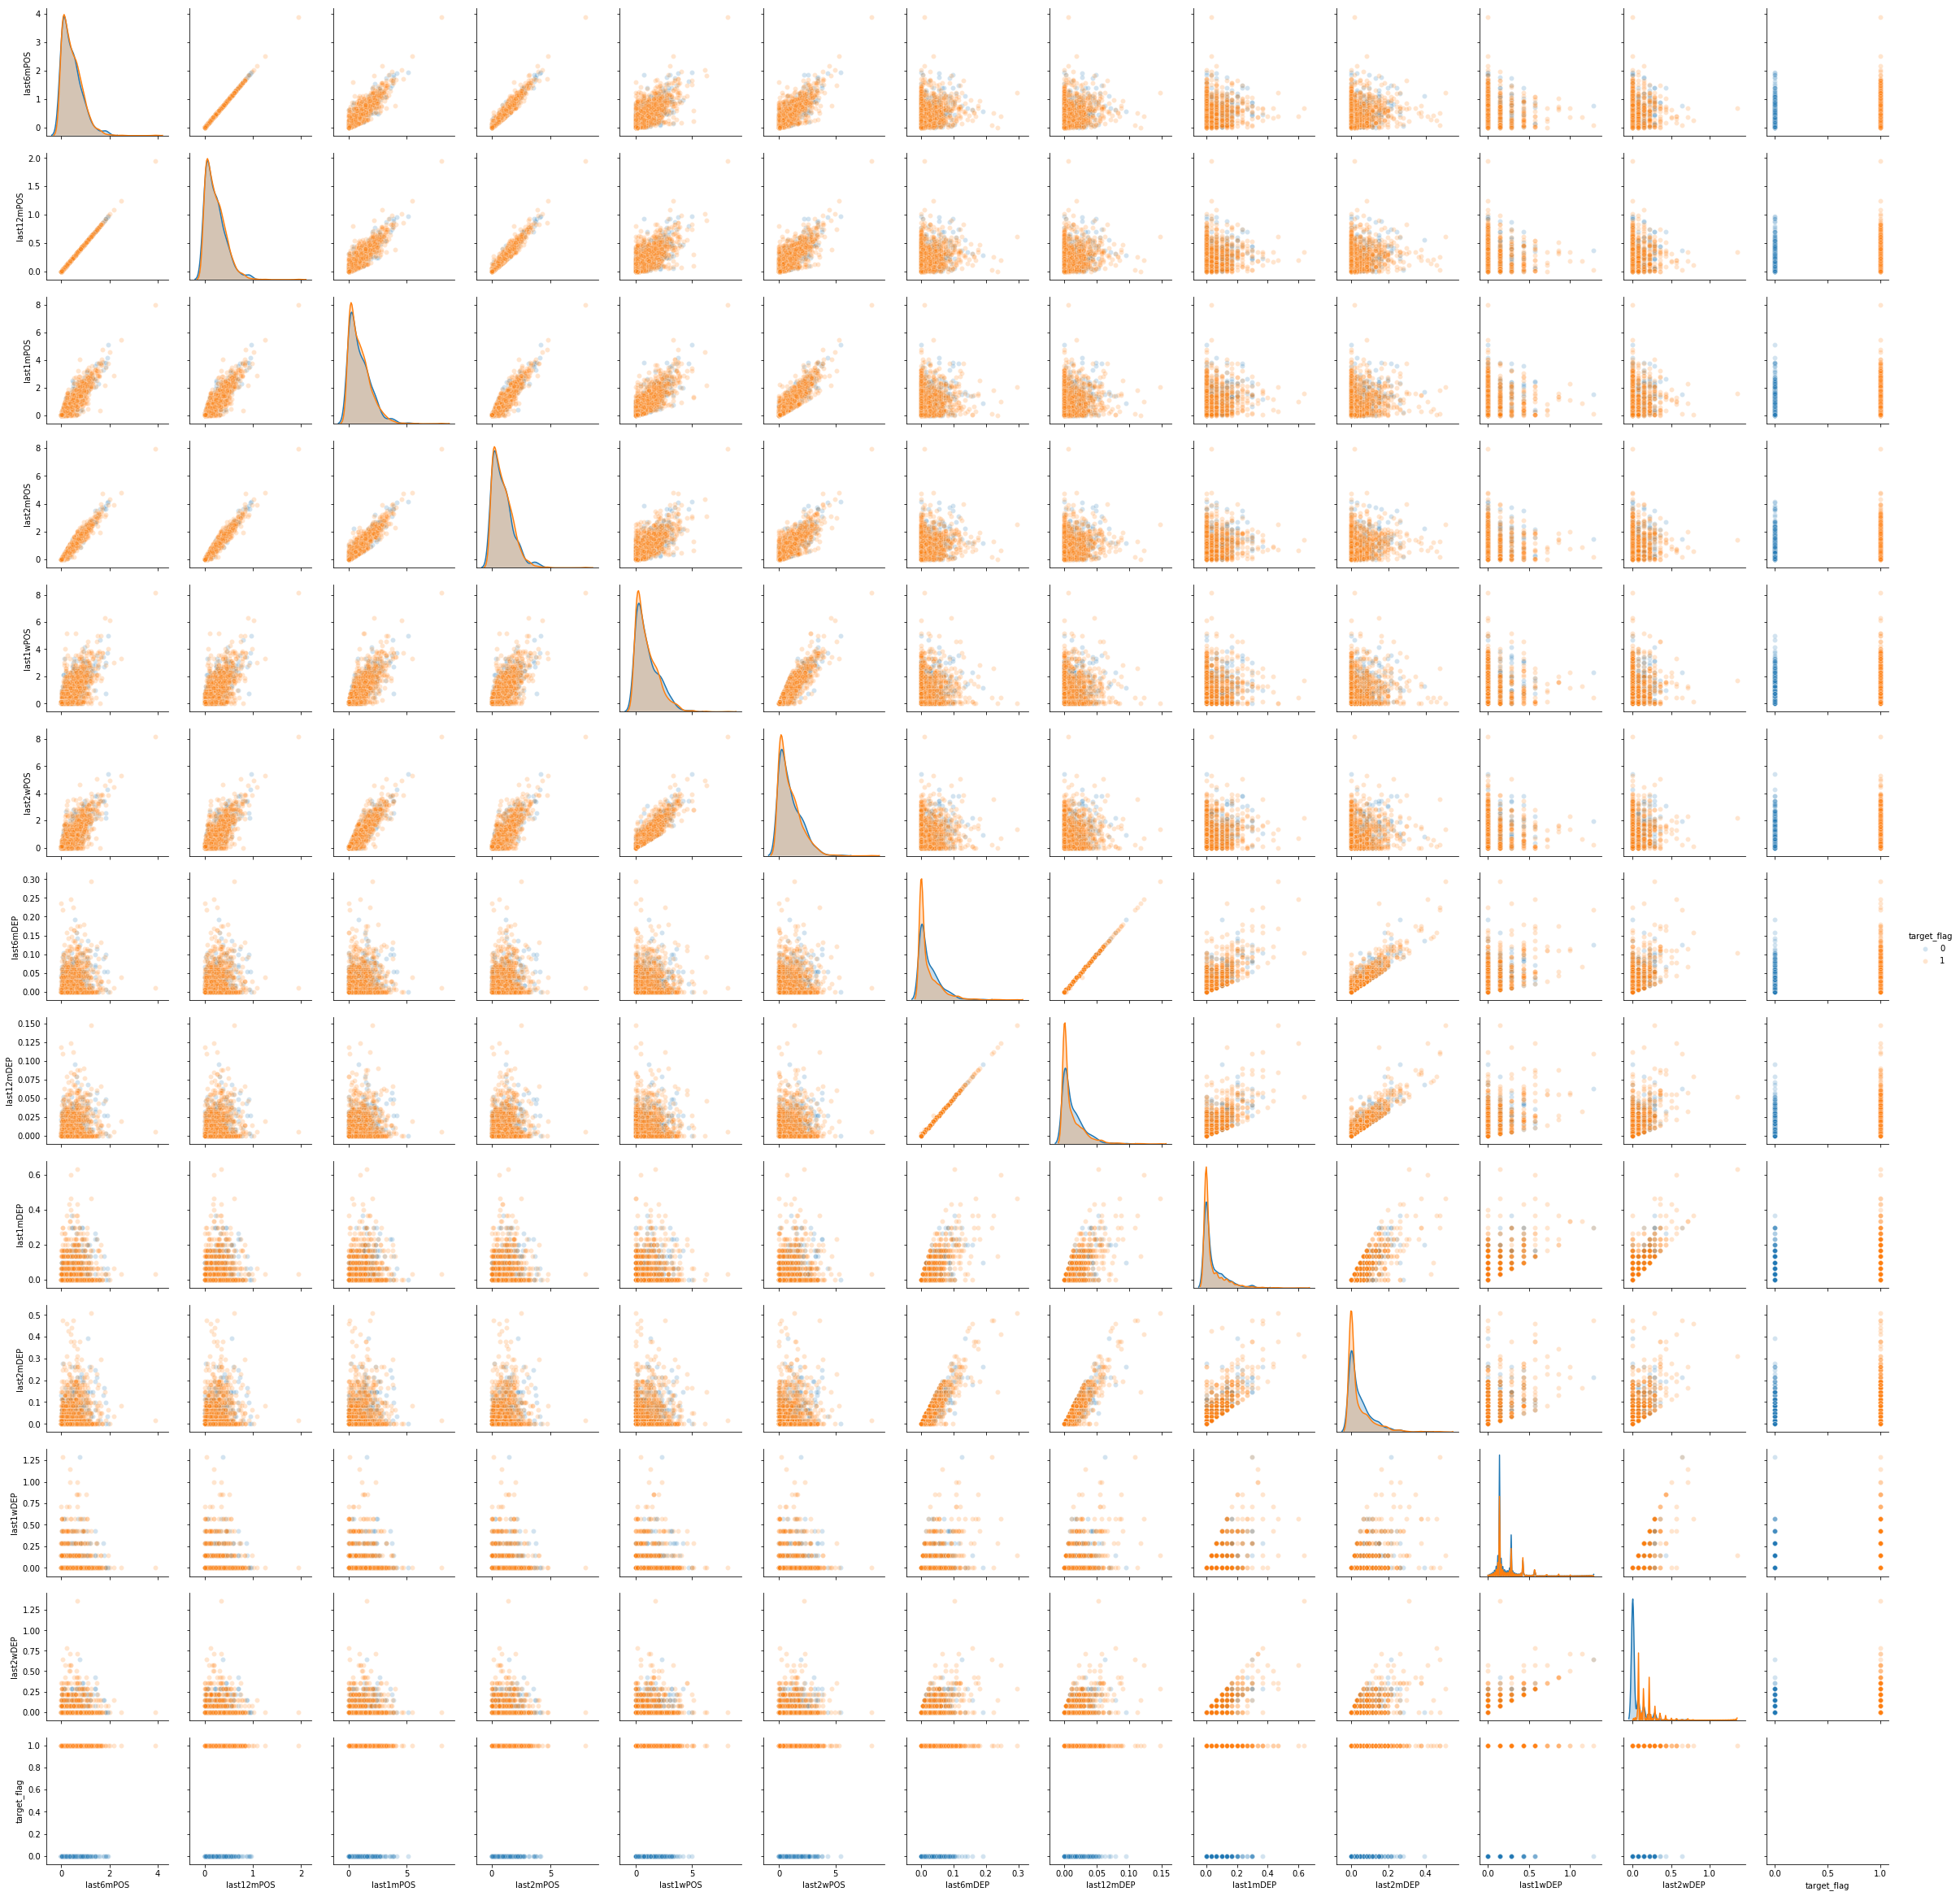

In [154]:
%%time
sns.pairplot(data=df_train[['last6mPOS','last12mPOS','last1mPOS','last2mPOS','last1wPOS','last2wPOS','last6mDEP','last12mDEP','last1mDEP','last2mDEP','last1wDEP','last2wDEP','target_flag']],plot_kws={'alpha':0.2},hue='target_flag');

По гистограмме можно предположить, что распределение last2wDEP для оттока смещено вправо относительно распределения неоттока => возможно полезная фича.

/home/truename/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/truename/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/truename/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/home/truename/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **pas

CPU times: user 18.8 s, sys: 112 ms, total: 18.9 s
Wall time: 18.9 s


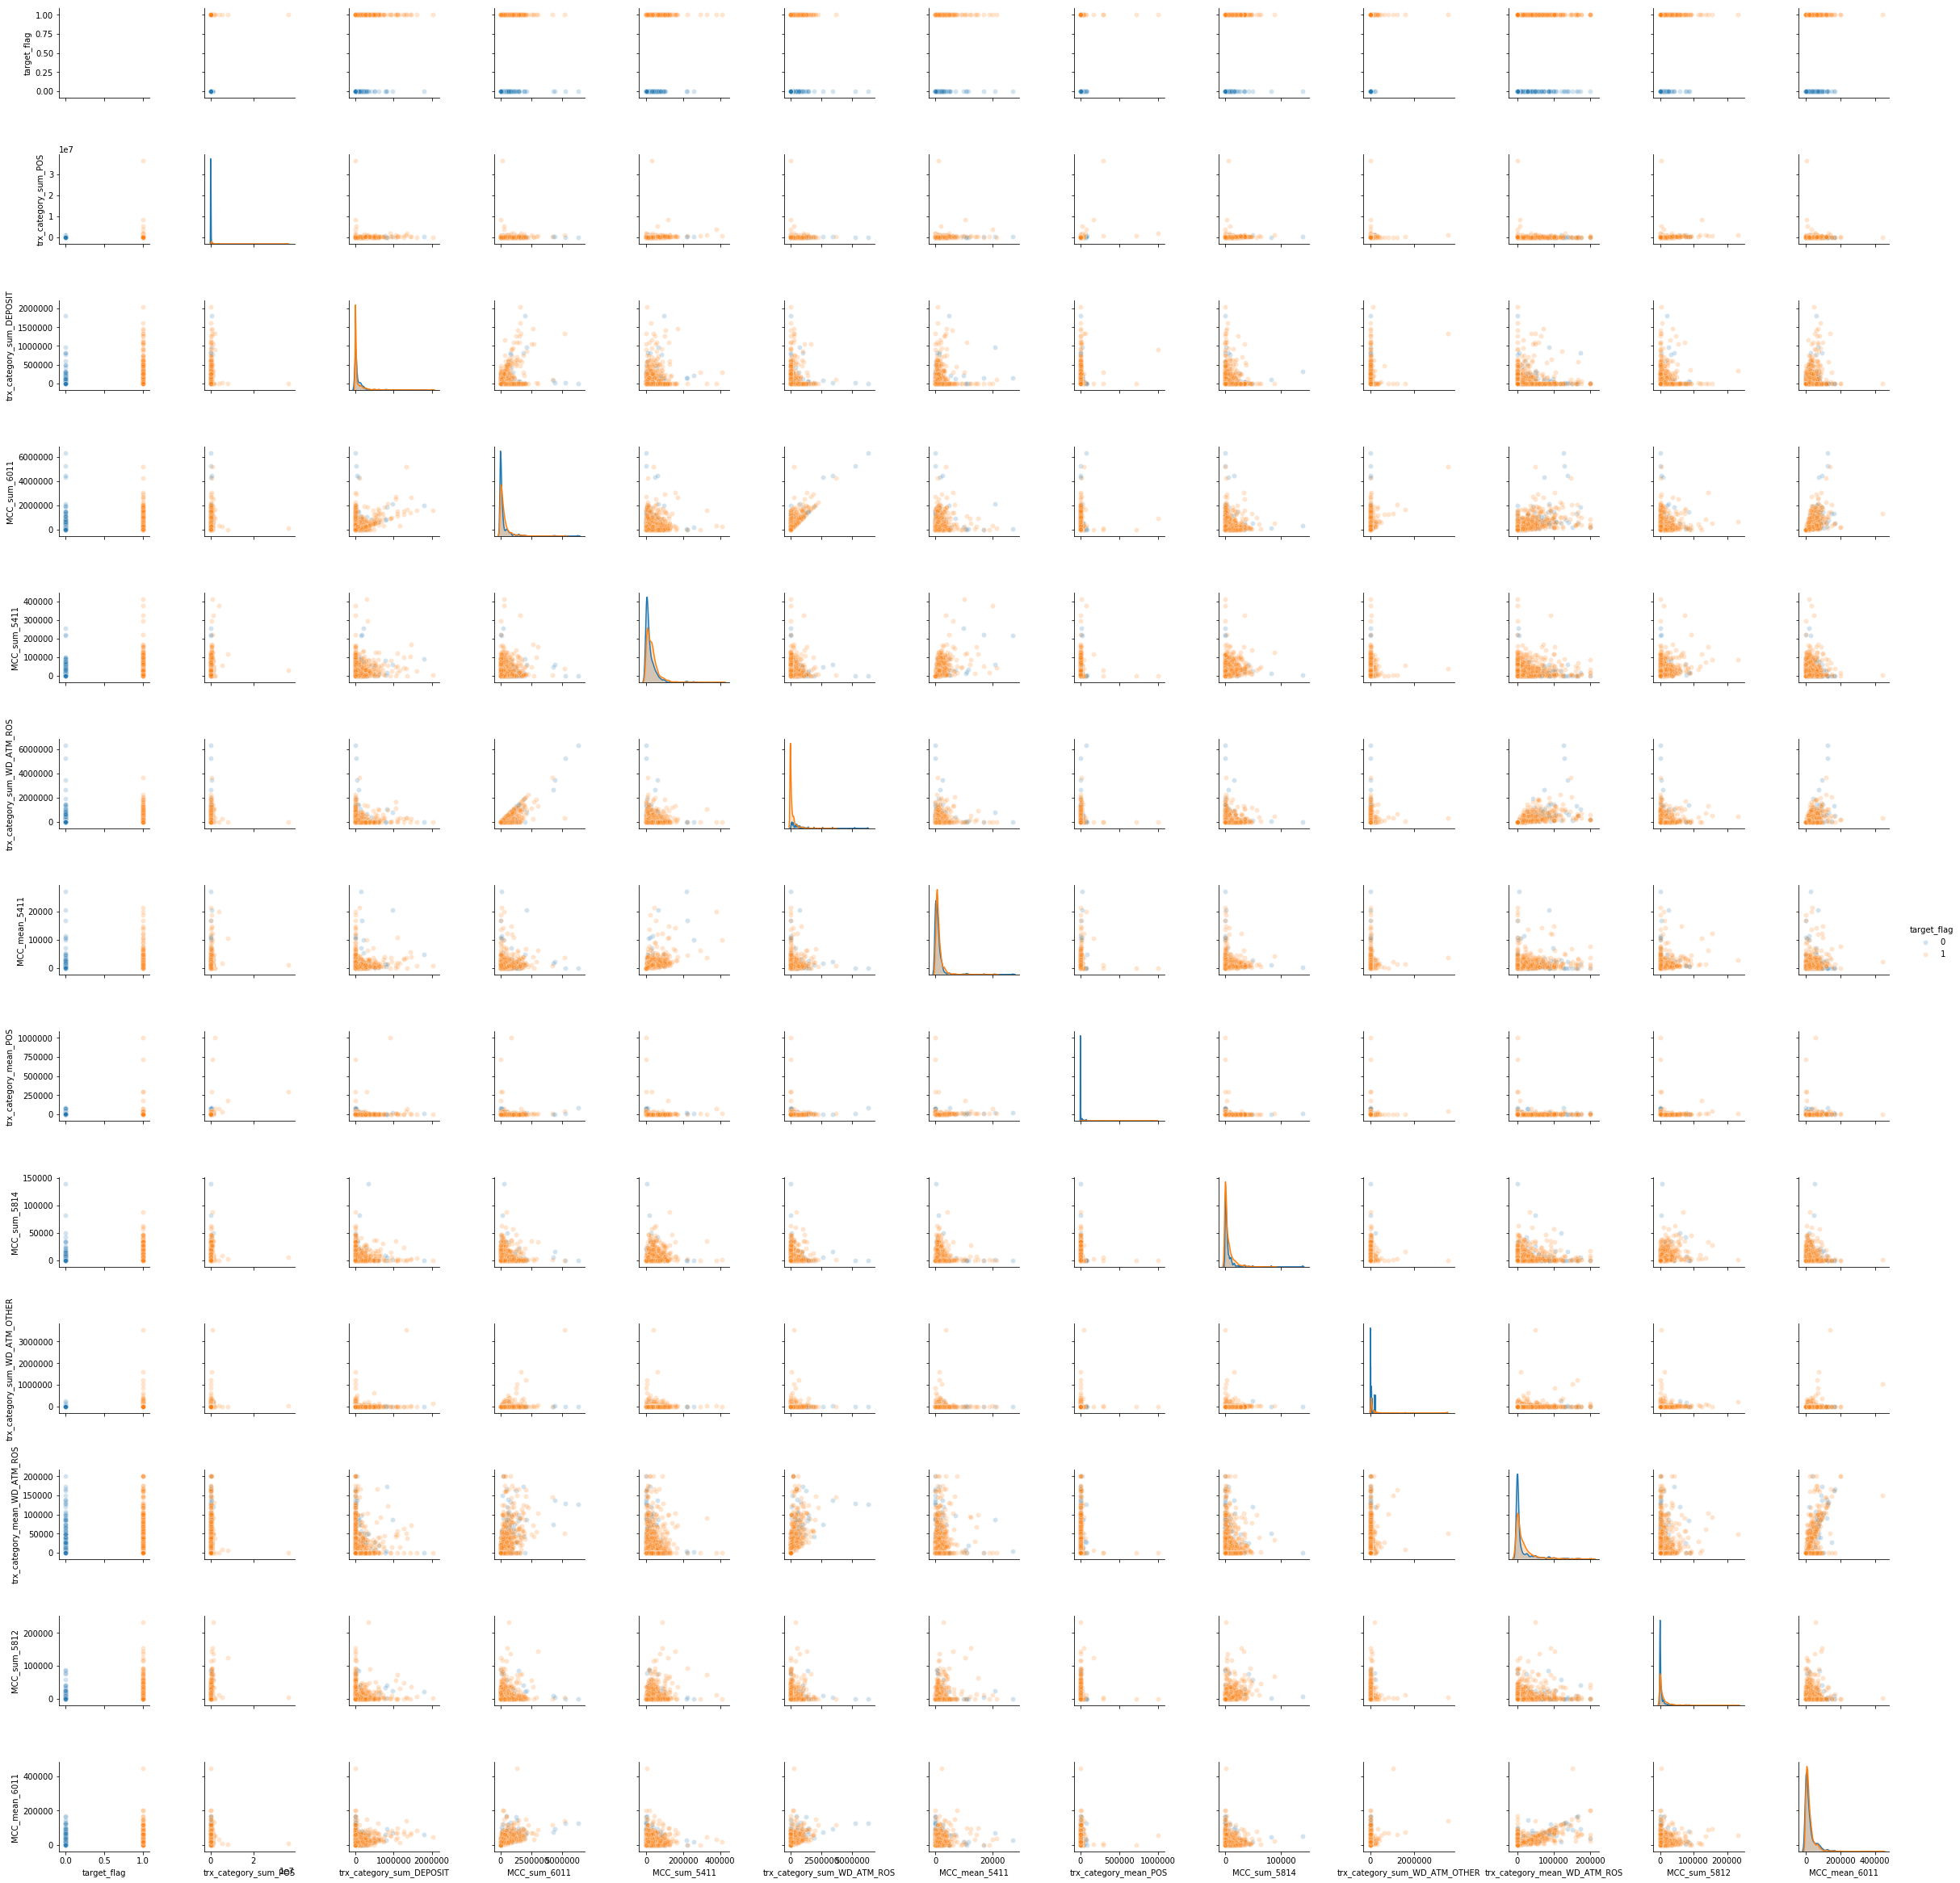

In [157]:
%%time
sns.pairplot(data=df_train[['target_flag','trx_category_sum_POS', 'trx_category_sum_DEPOSIT', 'MCC_sum_6011', 'MCC_sum_5411', 'trx_category_sum_WD_ATM_ROS', 'MCC_mean_5411', 'trx_category_mean_POS', \
                            'MCC_sum_5814', 'trx_category_sum_WD_ATM_OTHER', 'trx_category_mean_WD_ATM_ROS', 'MCC_sum_5812', 'MCC_mean_6011']],plot_kws={'alpha':0.2},hue='target_flag');

К примеру:
* По гистограммам можно предположить, что trx_category_sum_POS и trx_category_sum_DEPOSIT будут полезны, т.к. у trx_category_sum_POS распределение отточных смещено вправо относительно неотточных, а trx_category_sum_DEPOSIT - наоборот.

* Крайне интересен признак trx_category_mean_WD_ATM_ROS - большинство отточных не пользовались банкоматами Росбанка

Проведем gridsearch с кросс-валидацией по 10 фолдам на всех признаках, отбирая наилучшую модель.

In [108]:
parameters = {
    'n_estimators'      : [50,100,200,300,500],
    'max_depth'         : [10, 20, 30],
    'min_samples_split' : [2,10,100]
}

clf = GridSearchCV(RandomForestClassifier(), parameters, cv=10, n_jobs=-1)
clf.fit(X_train[cols], y_train)

print(clf.score(X_train[cols], y_train))
print(clf.best_params_)

1.0
{'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}


Посмотрим на важнейшие признаки наилучшей модели:

In [115]:
clf = RandomForestClassifier(n_estimators=200,max_depth=20,min_samples_split=2)
clf = clf.fit(X_train[cols], y_train)
fti = clf.feature_importances_
lst = []
for i, feat in enumerate(cols):
    lst.append((feat, fti[i]))

In [116]:
sorted(lst, key=lambda x: -x[1])[:10]

[('trx_category_sum_POS', 0.02784169985835646),
 ('MCC_sum_6011', 0.02255565551980345),
 ('MCC_sum_5411', 0.022501111844962122),
 ('trx_category_sum_WD_ATM_ROS', 0.020442420126491657),
 ('MCC_mean_5411', 0.01868047701796498),
 ('trx_category_mean_POS', 0.016204648896505917),
 ('MCC_sum_5814', 0.016157732800691497),
 ('trx_category_sum_WD_ATM_OTHER', 0.015129487088240601),
 ('trx_category_mean_WD_ATM_ROS', 0.01393892006025525),
 ('MCC_sum_5812', 0.01386734276164513)]

In [117]:
selected_cols = [x[0] for x in sorted(lst, key=lambda x: -x[1])[:11] if x[0] != 'cl_id']
print(selected_cols)

['trx_category_sum_POS', 'MCC_sum_6011', 'MCC_sum_5411', 'trx_category_sum_WD_ATM_ROS', 'MCC_mean_5411', 'trx_category_mean_POS', 'MCC_sum_5814', 'trx_category_sum_WD_ATM_OTHER', 'trx_category_mean_WD_ATM_ROS', 'MCC_sum_5812', 'MCC_mean_6011']


/home/truename/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/truename/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/truename/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/home/truename/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **pas

CPU times: user 14.9 s, sys: 88 ms, total: 15 s
Wall time: 15 s


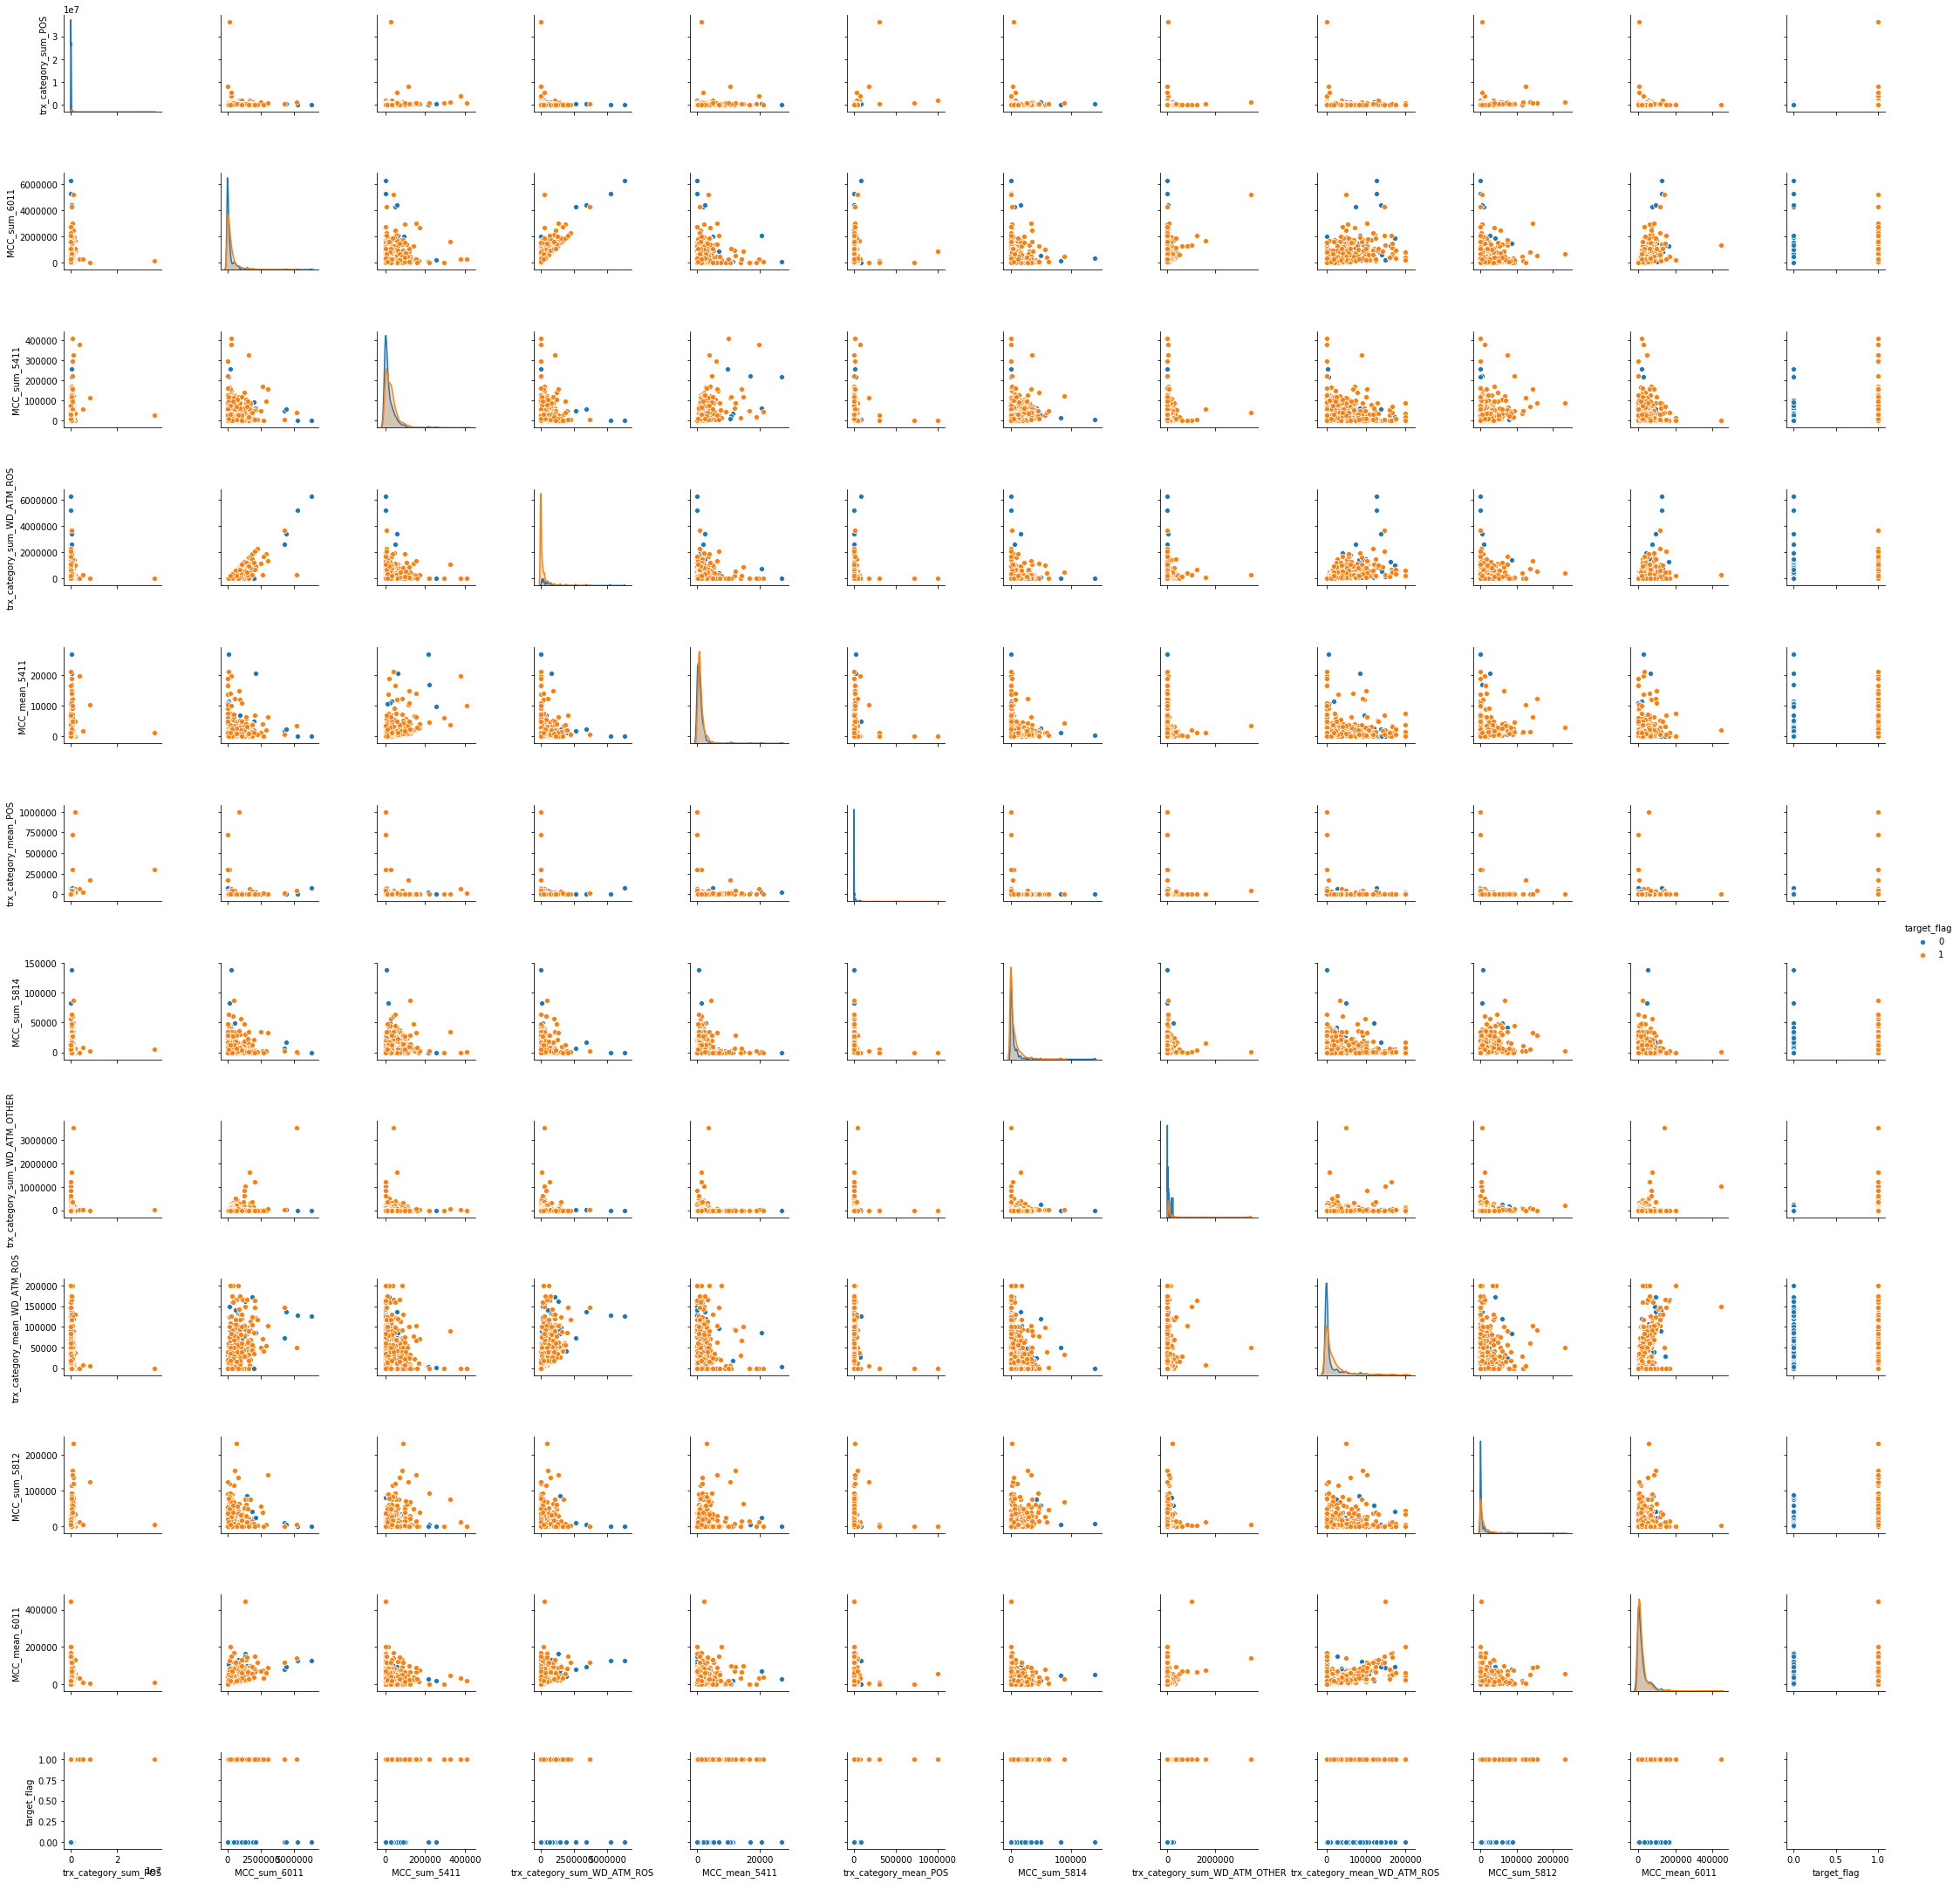

In [118]:
%%time
sns.pairplot(data=df_train[selected_cols + ['target_flag']],hue='target_flag');

In [113]:
clf = RandomForestClassifier(n_estimators=100,max_depth=30,min_samples_split=2)
clf = clf.fit(X_train[selected_cols], y_train)

y_train_predict = clf.predict_proba(X_train[selected_cols])[:, 1]
roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 2)
print("Train: ", roc_auc_train)

y_test_predict = clf.predict_proba(X_test[selected_cols])[:, 1]
roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 2)
print("Test: ", roc_auc_test)

Train:  1.0
Test:  0.8


In [120]:
clf = RandomForestClassifier(n_estimators=200,max_depth=20,min_samples_split=2)
clf = clf.fit(X_train[selected_cols], y_train)

y_train_predict = clf.predict_proba(X_train[selected_cols])[:, 1]
roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 2)
print("Train: ", roc_auc_train)

y_test_predict = clf.predict_proba(X_test[selected_cols])[:, 1]
roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 2)
print("Test: ", roc_auc_test)

Train:  1.0
Test:  0.8


In [135]:
selected_cols = [x[0] for x in sorted(lst, key=lambda x: -x[1])[:20] if x[0] != 'cl_id']
print(selected_cols)

['trx_category_sum_POS', 'MCC_sum_6011', 'MCC_sum_5411', 'trx_category_sum_WD_ATM_ROS', 'MCC_mean_5411', 'trx_category_mean_POS', 'MCC_sum_5814', 'trx_category_sum_WD_ATM_OTHER', 'trx_category_mean_WD_ATM_ROS', 'MCC_sum_5812', 'MCC_mean_6011', 'MCC_mean_5499', 'trx_category_mean_WD_ATM_OTHER', 'MCC_sum_5499', 'MCC_sum_5999', 'MCC_mean_5999', 'last2m', 'MCC_mean_5814', 'MCC_mean_5912', 'MCC_sum_5912']


In [151]:
clf = RandomForestClassifier(n_estimators=200,max_depth=15,min_samples_split=10)
clf = clf.fit(X_train[selected_cols], y_train)

y_train_predict = clf.predict_proba(X_train[selected_cols])[:, 1]
roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 2)
print("Train: ", roc_auc_train)

y_test_predict = clf.predict_proba(X_test[selected_cols])[:, 1]
roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 2)
print("Test: ", roc_auc_test)

Train:  1.0
Test:  0.81
